# Exploring Predictive Health Factors

**Overview**

Polycystic ovary syndrome (PCOS) is a common endocrine disorder that affects the reproductive health and quality of life of millions of women worldwide. Research has shown that lifestyle choices such as diet, exercise, stress management, etc. have a significant impact on the pathogenesis and symptom relief of PCOS. However, there are still many gaps in research on the relationship between lifestyle and PCOS, especially in terms of individual differences and comprehensive lifestyle interventions.

In order to promote research progress in this field, we are organizing the "Polycystic Ovary Syndrome (PCOS) Lifestyle Impact Research Competition". The aim is to use data-driven methods to deeply analyze the impact of lifestyle choices on PCOS, and provide scientific basis for clinical intervention and health management.

**Dataset Description**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the PCOS dataset.
Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

**About Dataset**

This dataset is designed to facilitate research and analysis on the impact of lifestyle choices on PCOS. It serves multiple purposes:
- Exploratory Data Analysis (EDA). Identifying trends, correlations, and patterns in lifestyle factors associated with PCOS.
- Predictive Modeling. Developing machine learning models to predict PCOS based on health metrics and lifestyle attributes.
- Health Research. Supporting studies on how factors like diet, physical activity, and stress levels contribute to PCOS prevalence and severity.
- Awareness & Education. Providing valuable insights for individuals, healthcare professionals, and policymakers about the importance of lifestyle management in reproductive health.

**Impact of the Research**

Findings derived from this competition could have significant implications for both scientific research and public health:
- Personalized Treatment Approaches. Insights into individual differences in lifestyle impact may help develop tailored intervention strategies for managing PCOS.
- Policy Development. Evidence-based recommendations could inform guidelines on nutrition, exercise, and stress management for women at risk of or diagnosed with PCOS.
- Healthcare Applications. The predictive models generated may aid in early diagnosis and improved clinical decision-making.
- Public Awareness. Increased understanding of modifiable lifestyle factors can empower individuals to take proactive steps in managing their reproductive health.

# Loading data

###  Loading and preliminary analysis of data

In [1]:
# installations
!pip install -U phik
!pip install -U lightgbm
!pip install -U xgboost
!pip install -U catboost
!pip install scikit-learn

In [2]:
#import standart libraries
import pandas as pd
import numpy as np

#import of libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#import of libraries for machine learning and data processing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

# import of libraries for data analysis
import phik

In [3]:
# loading of train dataset as data
data = pd.read_csv('./data/train.csv', index_col=0)

In [4]:
# loading of test  dataset as test
test = pd.read_csv('./data/test.csv', index_col=0)

In [5]:
# reset the indices in data and create a new ordinal index
data = data.reset_index(drop=True)

In [6]:
# write the function, that allows to recive all preliminary information
def datasets_information(datasets):
    for name, data in datasets.items():
        #recieve first rows
        print(f'Dataset: {name}')
        print('\nFirst rows:')
        print(data.head())
        print('\n')

        # display common information about dataset
        print('Info:')
        print(data.info())
        print('\n')

        # check for missing  values
        print('Missing values:')
        print(data.isna().sum())
        print('\n')

        # check for duplicates
        print('Duplicate rows:')
        print(data.duplicated().sum())
        print('\n')

# Create a dictionary with datasets
datasets ={
    'data': data,
    'test':test
           } 

In [7]:
datasets_information(datasets)

Dataset: data

First rows:
     Age  Weight_kg PCOS Hormonal_Imbalance Hyperandrogenism Hirsutism  \
0  20-25       64.0   No                 No               No        No   
1  15-20       55.0   No                 No               No        No   
2  15-20       91.0   No                 No               No       Yes   
3  15-20       56.0   No                 No               No        No   
4  15-20       47.0   No                Yes               No        No   

  Conception_Difficulty Insulin_Resistance Exercise_Frequency  \
0                    No                 No             Rarely   
1                    No                 No   6-8 Times a Week   
2                    No                 No             Rarely   
3                    No                 No   6-8 Times a Week   
4                    No                 No             Rarely   

                               Exercise_Type     Exercise_Duration  \
0  Cardio (e.g., running, cycling, swimming)            30 minutes 

The dataframe 'data' contains only 210 records. It has 13 columns: 12 of type object and 1 of type float. The data has a small number of missing values in almost every column, which we will replace or remove in the next step or in the pipeline. No duplicates found. 

The dataframe 'test' contains only 145 records. It has 12 columns: 11 of type object and 1 of type float. The data has a small number of missing values in almost every column, which we will replace or remove in the next step or in the pipeline. 1 Duplicate detected.

## Data Preprocessing

At the first stage, we will adjust the column names to the correct style.

In [8]:
# convert all column names in the data dataframe to lowercase:
data.columns = data.columns.str.lower()

In [9]:
data.head(1)

,age,weight_kg,pcos,hormonal_imbalance,hyperandrogenism,hirsutism,conception_difficulty,insulin_resistance,exercise_frequency,exercise_type,exercise_duration,sleep_hours,exercise_benefit
0,20-25,64.0,No,No,No,No,No,No,Rarely,"Cardio (e.g., running, cycling, swimming)",30 minutes,Less than 6 hours,Somewhat


In [10]:
# convert all column names in the test dataframe to lowercase:
test.columns = test.columns.str.lower()

In [11]:
# removing all missing values
data = data.dropna()

Let's take a look at the unique values of our categorical features.

In [12]:
def check_unique_values(data):
    # iterating through all columns in dataset
    for column in data.select_dtypes(include=['object']).columns:
        print(f" unique values in column '{column}':")
        print(data[column].unique())
        print('-' * 40)

In [13]:
check_unique_values(data)

 unique values in column 'age':
['20-25' '15-20' '45 and above' '30-35' '35-44' '25-30' 'Less than 20'
 '30-25' 'Less than 20-25']
----------------------------------------
 unique values in column 'pcos':
['No' 'Yes']
----------------------------------------
 unique values in column 'hormonal_imbalance':
['No' 'Yes' 'No, Yes, not diagnosed by a doctor' 'Yes Significantly']
----------------------------------------
 unique values in column 'hyperandrogenism':
['No' 'Yes']
----------------------------------------
 unique values in column 'hirsutism':
['No' 'Yes' 'No, Yes, not diagnosed by a doctor']
----------------------------------------
 unique values in column 'conception_difficulty':
['No' 'Yes, diagnosed by a doctor' 'Yes']
----------------------------------------
 unique values in column 'insulin_resistance':
['No' 'Yes']
----------------------------------------
 unique values in column 'exercise_frequency':
['Rarely' '6-8 Times a Week' 'Never' '1-2 Times a Week' '3-4 Times a Week'

In [14]:
check_unique_values(test)

 unique values in column 'age':
['20-25' 'Less than 20' '35-44' 'Less than 20-25' '30-30' 'Less than 20)'
 '30-35' '25-25' '50-60' '22-25' nan '20' '30-40' '45-49']
----------------------------------------
 unique values in column 'hormonal_imbalance':
['No' 'Yes' nan]
----------------------------------------
 unique values in column 'hyperandrogenism':
['No' 'Yes' nan]
----------------------------------------
 unique values in column 'hirsutism':
['No' 'Yes' nan]
----------------------------------------
 unique values in column 'conception_difficulty':
['No' 'Yes' nan 'Somewhat']
----------------------------------------
 unique values in column 'insulin_resistance':
['No' 'Yes' 'Yes Significantly' nan]
----------------------------------------
 unique values in column 'exercise_frequency':
['Rarely' '3-4 Times a Week' '6-8 Times a Week' 'Never' '1-2 Times a Week'
 'Less than 6-8 Times a Week' 'Less than 6 hours' nan '30-35' 'Daily'
 'Somewhat' '6-8 hours' '1/2 Times a Week']
----------

It looks like we will need to correct some values in the categorical features.

In [15]:
data['age'].unique()

array(['20-25', '15-20', '45 and above', '30-35', '35-44', '25-30',
       'Less than 20', '30-25', 'Less than 20-25'], dtype=object)

In [16]:
data['age'].value_counts()

age
20-25              113
15-20               42
Less than 20        17
35-44                4
25-30                4
45 and above         3
30-35                2
30-25                1
Less than 20-25      1
Name: count, dtype: int64

Some categories are illogical, and we will correct them to the proper names. We will also try to group the data into larger categories.

In [17]:
test['age'].value_counts()

age
20-25              95
Less than 20       37
30-35               2
35-44               1
Less than 20-25     1
30-30               1
Less than 20)       1
25-25               1
50-60               1
22-25               1
20                  1
30-40               1
45-49               1
Name: count, dtype: int64

In [18]:
data = data.copy()

In [19]:
data['age'].value_counts()

age
20-25              113
15-20               42
Less than 20        17
35-44                4
25-30                4
45 and above         3
30-35                2
30-25                1
Less than 20-25      1
Name: count, dtype: int64

In [20]:
test['age'].value_counts()

age
20-25              95
Less than 20       37
30-35               2
35-44               1
Less than 20-25     1
30-30               1
Less than 20)       1
25-25               1
50-60               1
22-25               1
20                  1
30-40               1
45-49               1
Name: count, dtype: int64

In [21]:
data['pcos'].unique()

array(['No', 'Yes'], dtype=object)

Our target feature indicates the presence or absence of PCOS. There are only two values: "No" and "Yes".

In [22]:
data['pcos'].value_counts()

pcos
No     144
Yes     43
Name: count, dtype: int64

As we can see, there is a class imbalance—46 instances of the positive class versus 164 of the negative class, a 3.5-fold difference. This needs to be considered when building the models.

In [23]:
data['hormonal_imbalance'].unique()

array(['No', 'Yes', 'No, Yes, not diagnosed by a doctor',
       'Yes Significantly'], dtype=object)

In [24]:
data['hormonal_imbalance'].value_counts()

hormonal_imbalance
Yes                                   102
No                                     83
No, Yes, not diagnosed by a doctor      1
Yes Significantly                       1
Name: count, dtype: int64

Here, we also need to clean up the two values.

In [25]:
data['hormonal_imbalance'] = data['hormonal_imbalance'].replace({'No, Yes, not diagnosed by a doctor': 'No', 'Yes Significantly': 'Yes'})

In [26]:
data['hormonal_imbalance'].value_counts()

hormonal_imbalance
Yes    103
No      84
Name: count, dtype: int64

In [27]:
test['hormonal_imbalance'].value_counts()

hormonal_imbalance
Yes    79
No     63
Name: count, dtype: int64

In [28]:
data['hyperandrogenism'].unique()

array(['No', 'Yes'], dtype=object)

In [29]:
test['hyperandrogenism'].unique()

array(['No', 'Yes', nan], dtype=object)

In [30]:
data['hirsutism'].value_counts()

hirsutism
No                                    131
Yes                                    54
No, Yes, not diagnosed by a doctor      2
Name: count, dtype: int64

In [31]:
data['hirsutism'] = data['hirsutism'].replace({'No, Yes, not diagnosed by a doctor': 'No'})

In [32]:
data['hirsutism'].value_counts()

hirsutism
No     133
Yes     54
Name: count, dtype: int64

In [33]:
test['hirsutism'].value_counts()

hirsutism
No     113
Yes     30
Name: count, dtype: int64

In [34]:
data['conception_difficulty'].unique()

array(['No', 'Yes, diagnosed by a doctor', 'Yes'], dtype=object)

In [35]:
data['conception_difficulty'] = data['conception_difficulty'].replace({'No, Yes, not diagnosed by a doctor': 'No', 'Yes, diagnosed by a doctor': 'Yes'})

In [36]:
data['conception_difficulty'].value_counts()

conception_difficulty
No     180
Yes      7
Name: count, dtype: int64

In [37]:
test['conception_difficulty'].value_counts()

conception_difficulty
No          137
Yes           5
Somewhat      1
Name: count, dtype: int64

In [38]:
test['conception_difficulty'] = test['conception_difficulty'].replace({'Somewhat': 'Yes'})

In [39]:
data['insulin_resistance'].unique()

array(['No', 'Yes'], dtype=object)

In [40]:
test['insulin_resistance'].unique()

array(['No', 'Yes', 'Yes Significantly', nan], dtype=object)

In [41]:
test['insulin_resistance'] = test['insulin_resistance'].replace({'Yes Significantly': 'Yes'})

In [42]:
data['exercise_frequency'].unique()

array(['Rarely', '6-8 Times a Week', 'Never', '1-2 Times a Week',
       '3-4 Times a Week', '6-8 hours', 'Less than usual',
       'Less than 6 hours'], dtype=object)

In [43]:
data['exercise_frequency'].value_counts()

exercise_frequency
Rarely               90
1-2 Times a Week     32
Never                27
3-4 Times a Week     19
6-8 Times a Week     16
6-8 hours             1
Less than usual       1
Less than 6 hours     1
Name: count, dtype: int64

In [44]:
data['exercise_frequency'].value_counts()

exercise_frequency
Rarely               90
1-2 Times a Week     32
Never                27
3-4 Times a Week     19
6-8 Times a Week     16
6-8 hours             1
Less than usual       1
Less than 6 hours     1
Name: count, dtype: int64

In [45]:
test['exercise_frequency'].value_counts() 

exercise_frequency
Rarely                        82
1-2 Times a Week              32
Never                         10
3-4 Times a Week               7
6-8 Times a Week               5
Daily                          2
Less than 6-8 Times a Week     1
Less than 6 hours              1
30-35                          1
Somewhat                       1
6-8 hours                      1
1/2 Times a Week               1
Name: count, dtype: int64

In [46]:
data['exercise_type'].value_counts()

exercise_type
No Exercise                                                                                                                                                84
Cardio (e.g., running, cycling, swimming)                                                                                                                  44
Cardio (e.g.                                                                                                                                               24
Flexibility and balance (e.g., yoga, pilates)                                                                                                              14
Strength training (e.g., weightlifting, resistance exercises)                                                                                               5
Cardio (e.g., running, cycling, swimming), Strength training (e.g., weightlifting, resistance exercises)                                                    4
High-intensity interval training (HIIT

In [47]:
data['exercise_type'].value_counts()

exercise_type
No Exercise                                                                                                                                                84
Cardio (e.g., running, cycling, swimming)                                                                                                                  44
Cardio (e.g.                                                                                                                                               24
Flexibility and balance (e.g., yoga, pilates)                                                                                                              14
Strength training (e.g., weightlifting, resistance exercises)                                                                                               5
Cardio (e.g., running, cycling, swimming), Strength training (e.g., weightlifting, resistance exercises)                                                    4
High-intensity interval training (HIIT

In [48]:
test['exercise_type'].value_counts()

exercise_type
Cardio (e.g.                     65
No Exercise                      63
Flexibility and balance (e.g.     7
Strength training (e.g.           2
Strength training                 1
Yes Significantly                 1
No                                1
Sleep_Benefit                     1
Not Applicable                    1
Somewhat                          1
Strength (e.g.                    1
Name: count, dtype: int64

In [49]:
data['exercise_duration'].unique()

array(['30 minutes', 'Less than 30 minutes', '45 minutes',
       'Not Applicable', 'More than 30 minutes', '20 minutes',
       'Less than 6 hours', '30 minutes to 1 hour'], dtype=object)

In [50]:
data['exercise_duration'].value_counts()

exercise_duration
Not Applicable          76
Less than 30 minutes    56
30 minutes              30
45 minutes              15
More than 30 minutes     7
20 minutes               1
Less than 6 hours        1
30 minutes to 1 hour     1
Name: count, dtype: int64

In [51]:
test['exercise_duration'].value_counts()

exercise_duration
Not Applicable          58
Less than 30 minutes    50
30 minutes              20
30 minutes to 1 hour     6
6-8 hours                2
Less than 20 minutes     2
3-4 Times a Week         2
20 minutes               1
Less than 6 hours        1
Not Much                 1
1-2 Times a Week         1
40 minutes               1
Name: count, dtype: int64

In [52]:
data['exercise_duration'].value_counts()

exercise_duration
Not Applicable          76
Less than 30 minutes    56
30 minutes              30
45 minutes              15
More than 30 minutes     7
20 minutes               1
Less than 6 hours        1
30 minutes to 1 hour     1
Name: count, dtype: int64

In [53]:
test['exercise_duration'].value_counts()

exercise_duration
Not Applicable          58
Less than 30 minutes    50
30 minutes              20
30 minutes to 1 hour     6
6-8 hours                2
Less than 20 minutes     2
3-4 Times a Week         2
20 minutes               1
Less than 6 hours        1
Not Much                 1
1-2 Times a Week         1
40 minutes               1
Name: count, dtype: int64

In [54]:
data['sleep_hours'].unique()

array(['Less than 6 hours', '6-8 hours', '9-12 hours',
       'More than 12 hours', '3-4 hours'], dtype=object)

In [55]:
data['sleep_hours'].value_counts()

sleep_hours
6-8 hours             120
Less than 6 hours      52
9-12 hours             13
More than 12 hours      1
3-4 hours               1
Name: count, dtype: int64

In [56]:
test['sleep_hours'].value_counts()

sleep_hours
6-8 hours            100
Less than 6 hours     34
9-12 hours             5
3-4 hours              2
6-8 Times a Week       1
6-12 hours             1
20 minutes             1
Name: count, dtype: int64

In [57]:
data['exercise_benefit'].value_counts()

exercise_benefit
Somewhat             120
Not at All            25
Yes Significantly     22
Not Much              20
Name: count, dtype: int64

In [58]:
test['exercise_benefit'].value_counts()

exercise_benefit
Somewhat             102
Not Much              17
Yes Significantly     15
Not at All            10
Name: count, dtype: int64

In [59]:
test['exercise_benefit'].value_counts()

exercise_benefit
Somewhat             102
Not Much              17
Yes Significantly     15
Not at All            10
Name: count, dtype: int64

In [60]:
data['exercise_benefit'].value_counts()

exercise_benefit
Somewhat             120
Not at All            25
Yes Significantly     22
Not Much              20
Name: count, dtype: int64

In [61]:
# removing all missing values
data = data.dropna()

## Visualization and analysis of quantitative and categorical features.

Let's take a look at the statistical results for the feature 'weight_kg'.

In [62]:
# display basic statistical summary for 'weight_kg'
data.describe()

,weight_kg
count,187.000000
mean,56.278610
std,12.917437
min,20.000000
25%,48.000000
50%,55.000000
75%,64.500000
max,116.000000


The provided statistics for the weight_kg column show that there are 182 observations with an average weight of 56.01 kg and a standard deviation of 12.43 kg, indicating a notable spread in the data. The minimum weight is 20 kg, while the maximum is 116 kg. The 25th percentile is 48 kg, the median is 55 kg, and the 75th percentile is 64 kg, suggesting that most weights are concentrated between 48 and 64 kg.

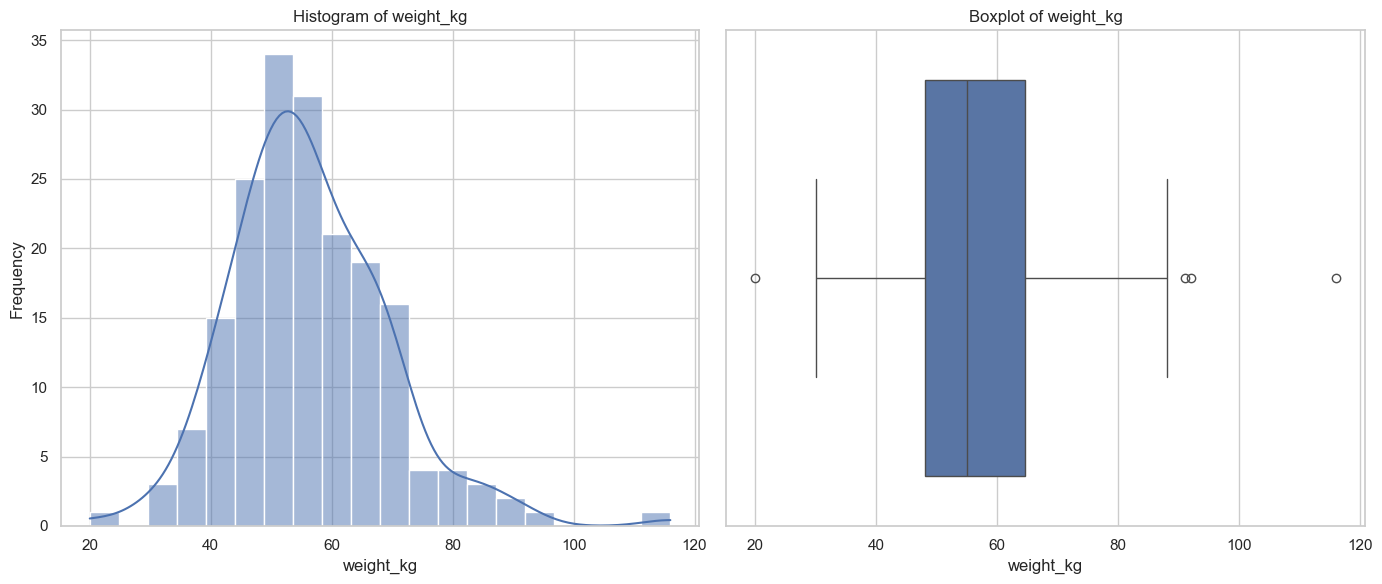

In [63]:
# setting the plot style
sns.set(style="whitegrid")
# create a figure and axes for the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# plot a histogram
sns.histplot(data['weight_kg'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Histogram of weight_kg')
axes[0].set_xlabel('weight_kg')
axes[0].set_ylabel('Frequency')
# plot a boxplot
sns.boxplot(x= data['weight_kg'], ax=axes[1])
axes[1].set_title('Boxplot of weight_kg')
axes[1].set_xlabel('weight_kg')

# display the plot on the screen
plt.tight_layout()
plt.show()

According to the boxplot, there are a small number of outliers below 30 kg and above 90 kg.

Let's visualize the numerical features in relation to the target - 'pcos'. 

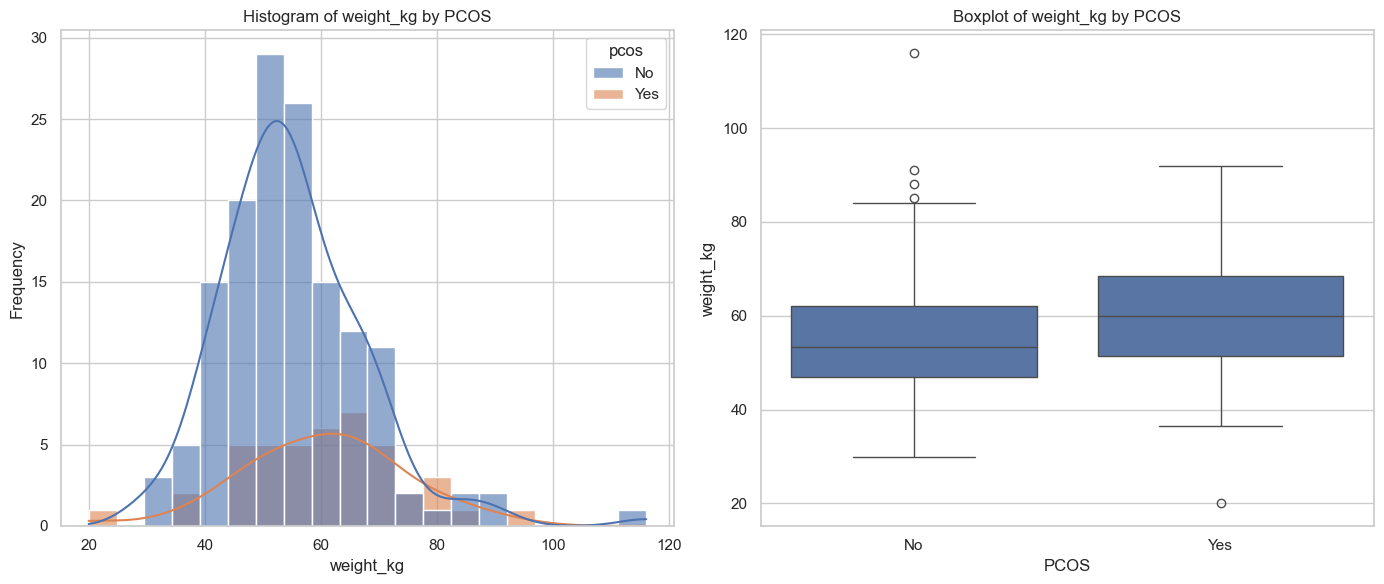

In [64]:
# setting the plot style
sns.set(style="whitegrid")

# create a figure and axes for the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# plot a histogram in relation to the target - 'pcos'
sns.histplot(data=data, x='weight_kg', hue='pcos', bins=20, kde=True, ax=axes[0], alpha=0.6)
axes[0].set_title('Histogram of weight_kg by PCOS')
axes[0].set_xlabel('weight_kg')
axes[0].set_ylabel('Frequency')

# plot a boxplot in relation to the target - 'pcos'
sns.boxplot(x='pcos', y='weight_kg', data=data, ax=axes[1])
axes[1].set_title('Boxplot of weight_kg by PCOS')
axes[1].set_xlabel('PCOS')
axes[1].set_ylabel('weight_kg')

# display the plot on the screen
plt.tight_layout()
plt.show()

The center of the weight distribution plot for people with PCOS is slightly shifted to the right. It can also be noted in the boxplot that the average weight of people with PCOS is higher than that of healthy individuals.

In [65]:
data.columns

Index(['age', 'weight_kg', 'pcos', 'hormonal_imbalance', 'hyperandrogenism',
       'hirsutism', 'conception_difficulty', 'insulin_resistance',
       'exercise_frequency', 'exercise_type', 'exercise_duration',
       'sleep_hours', 'exercise_benefit'],
      dtype='object')

In [66]:
#Let's write a function to plot a histogram for each categorical feature and discrete value.
#First, specify which features are categorical and which are discrete values.
categorical_disc_columns = ['age', 'pcos', 'hormonal_imbalance', 'hyperandrogenism',
       'hirsutism', 'conception_difficulty', 'insulin_resistance',
       'exercise_frequency', 'exercise_type', 'exercise_duration',
       'sleep_hours', 'exercise_benefit']

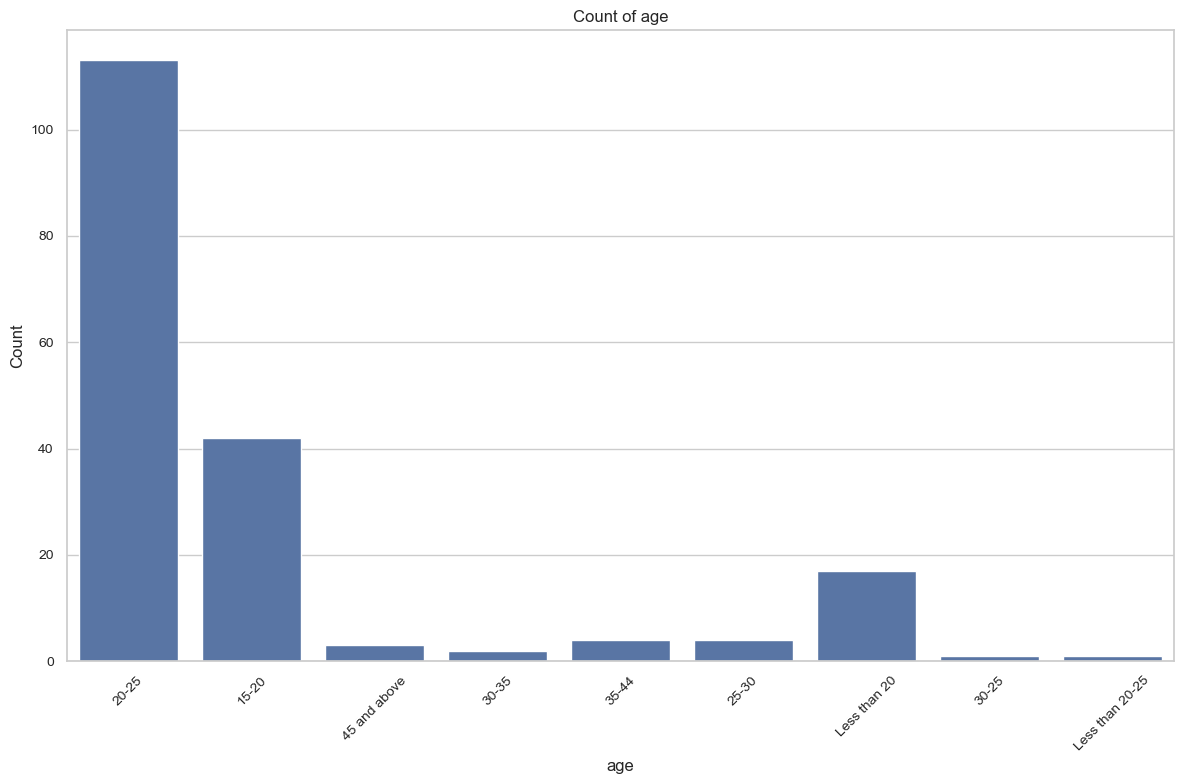

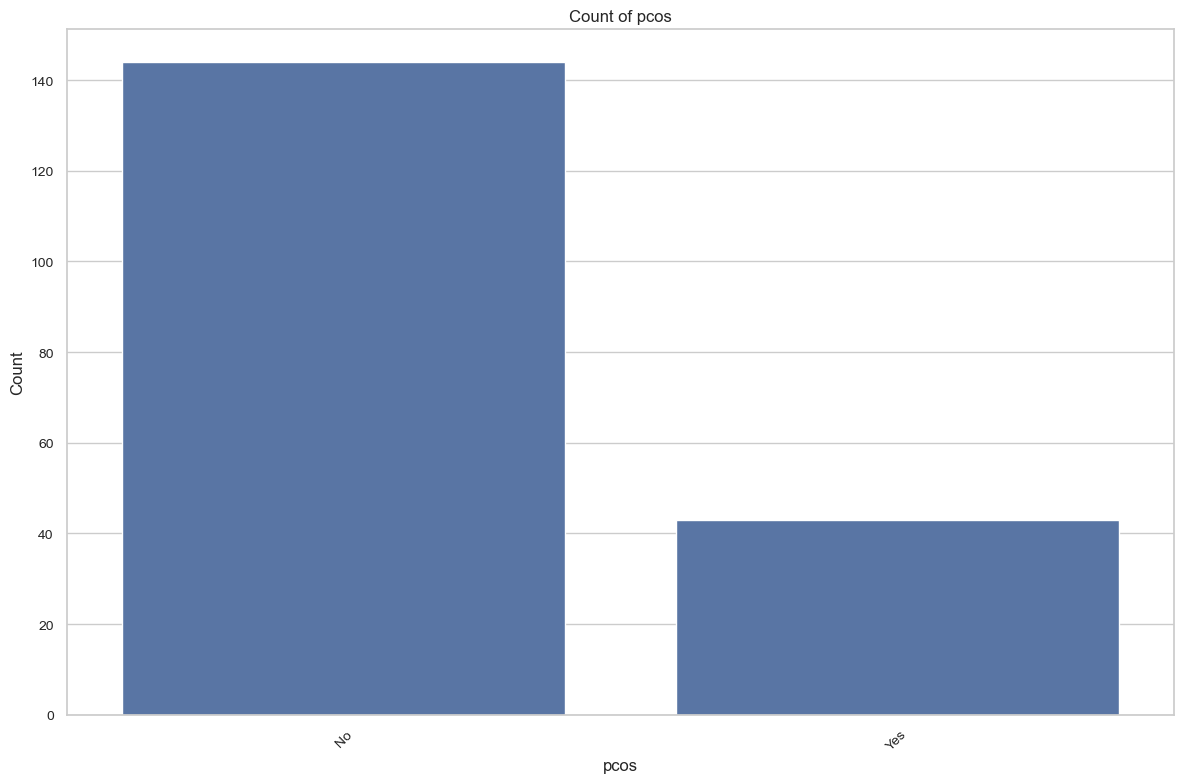

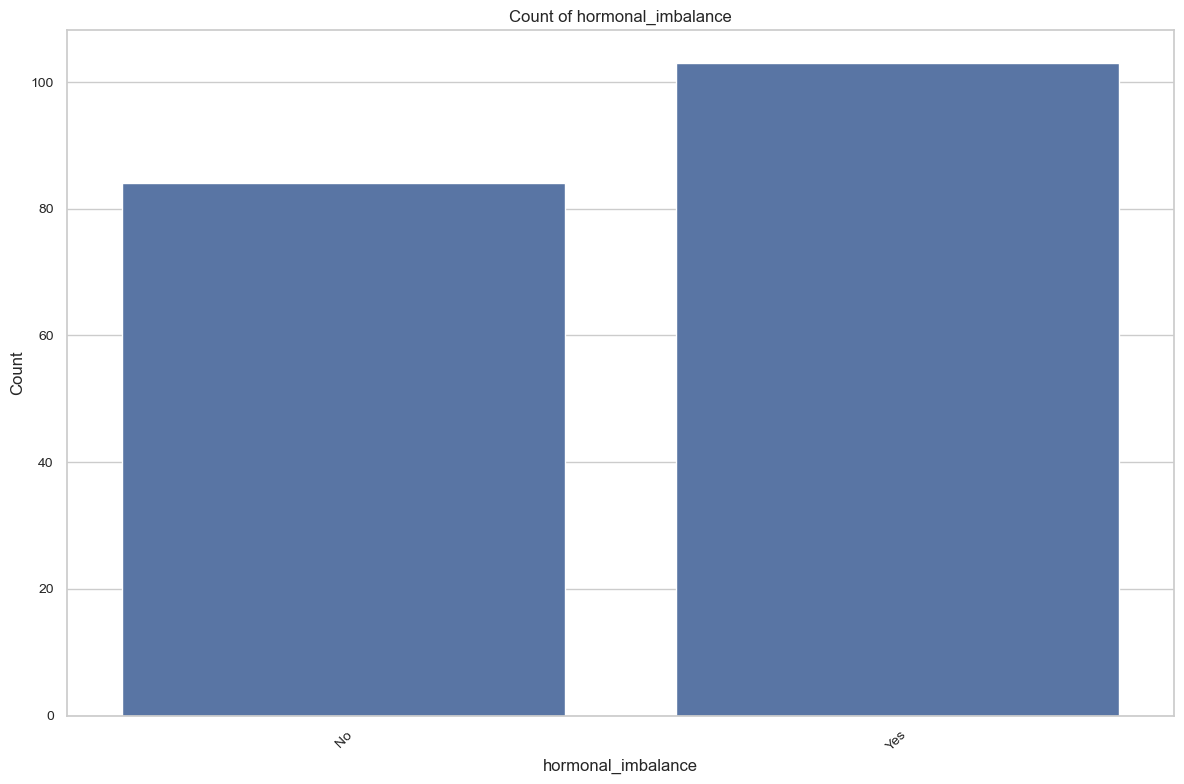

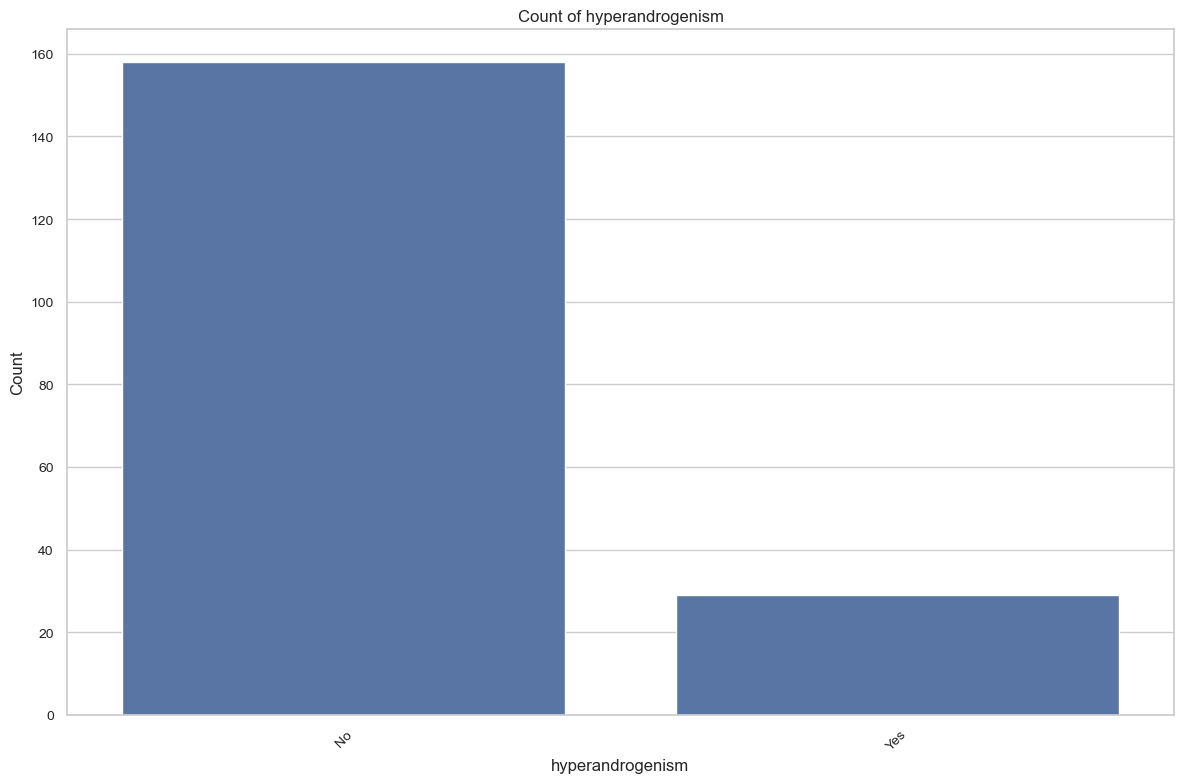

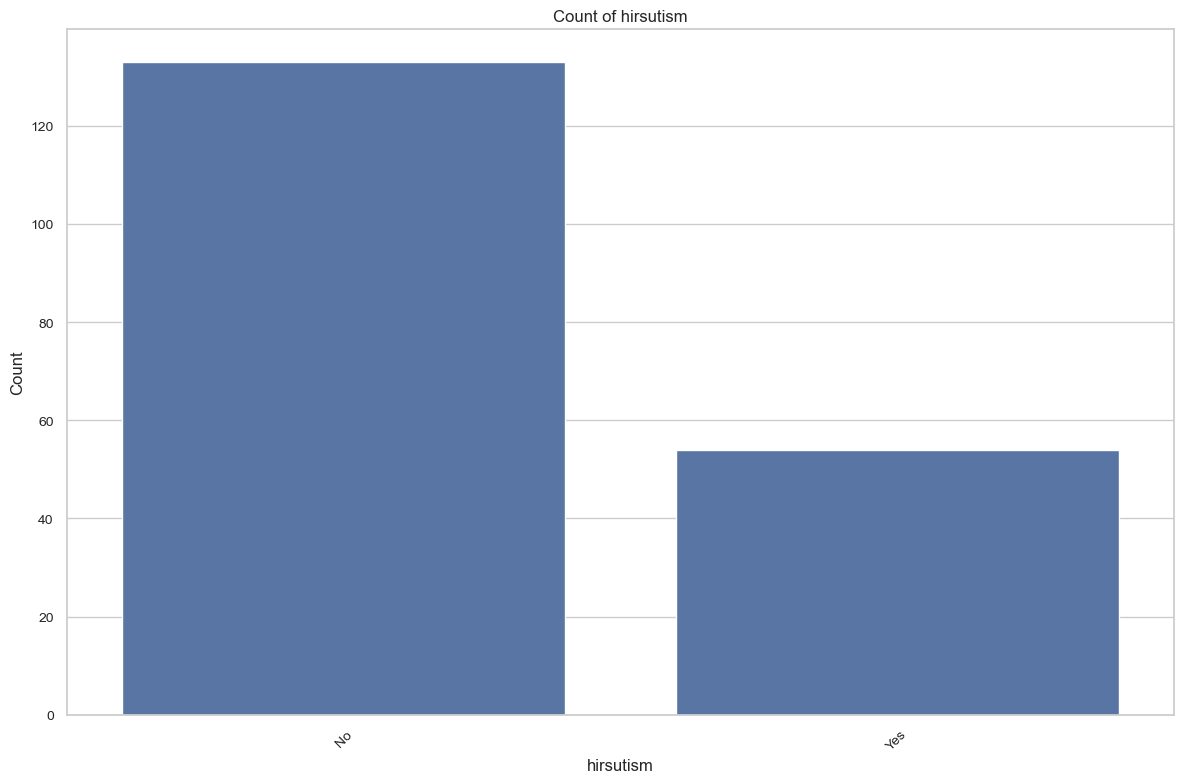

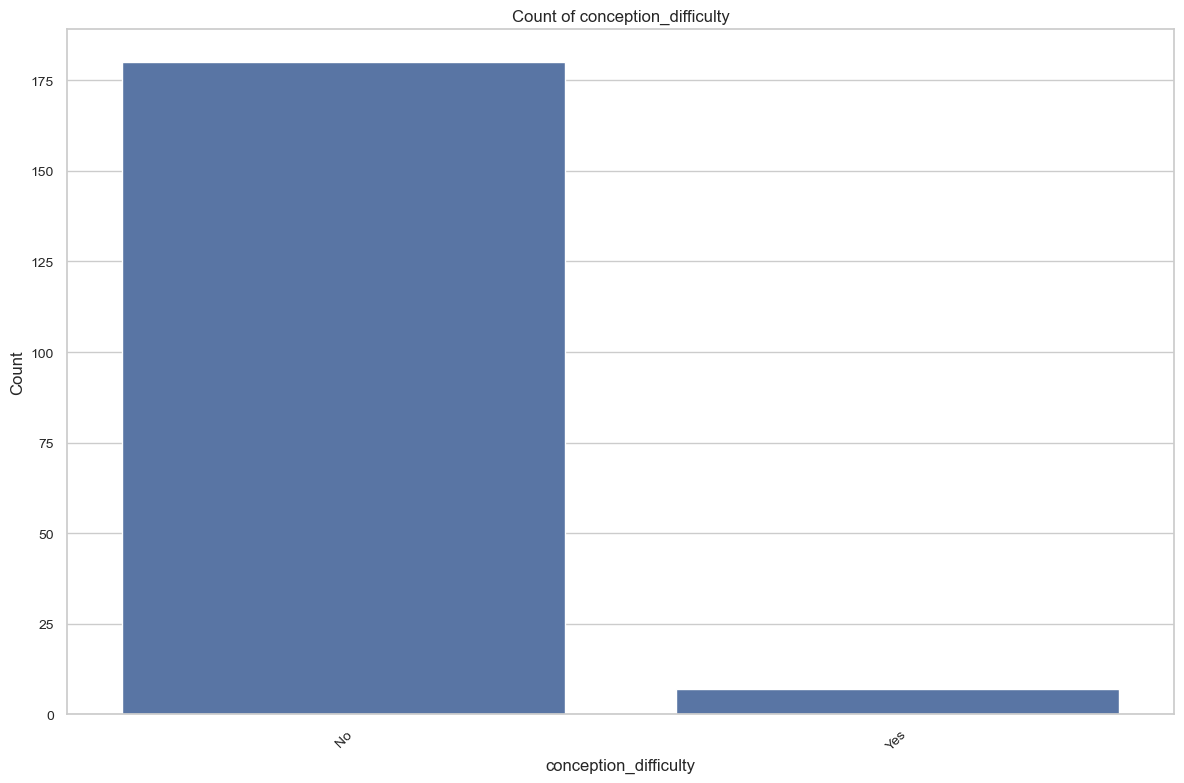

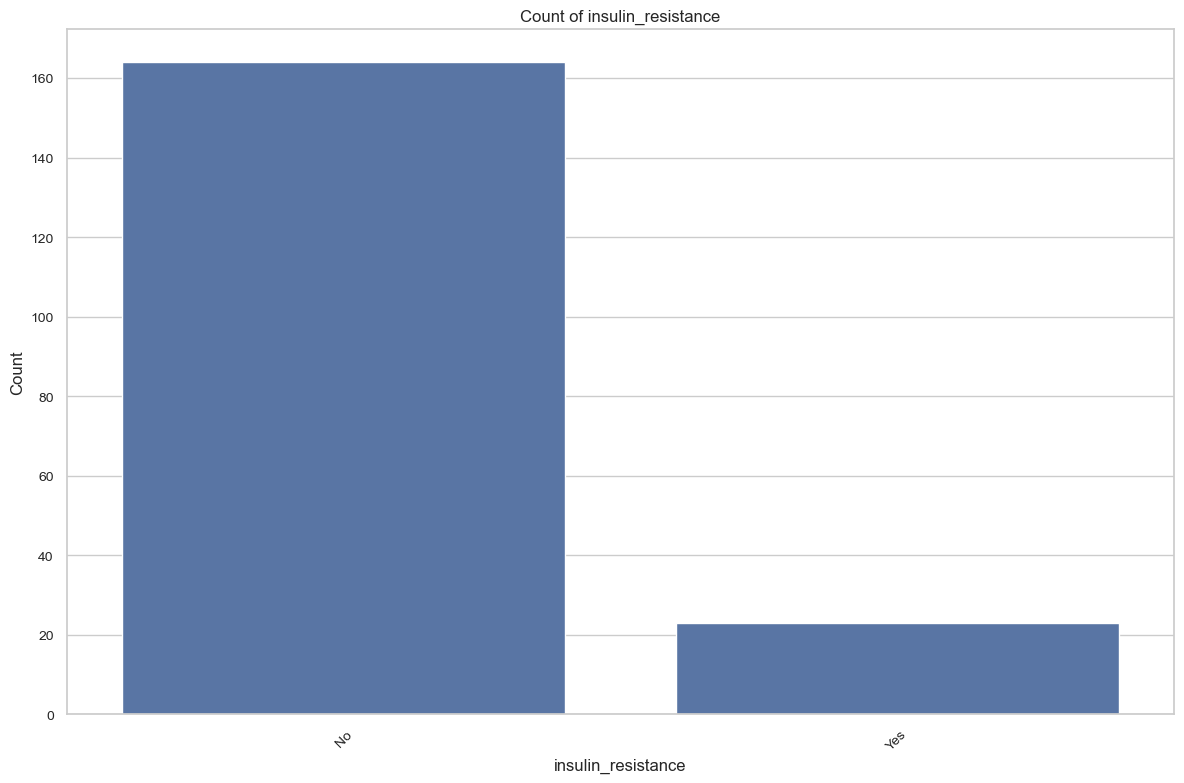

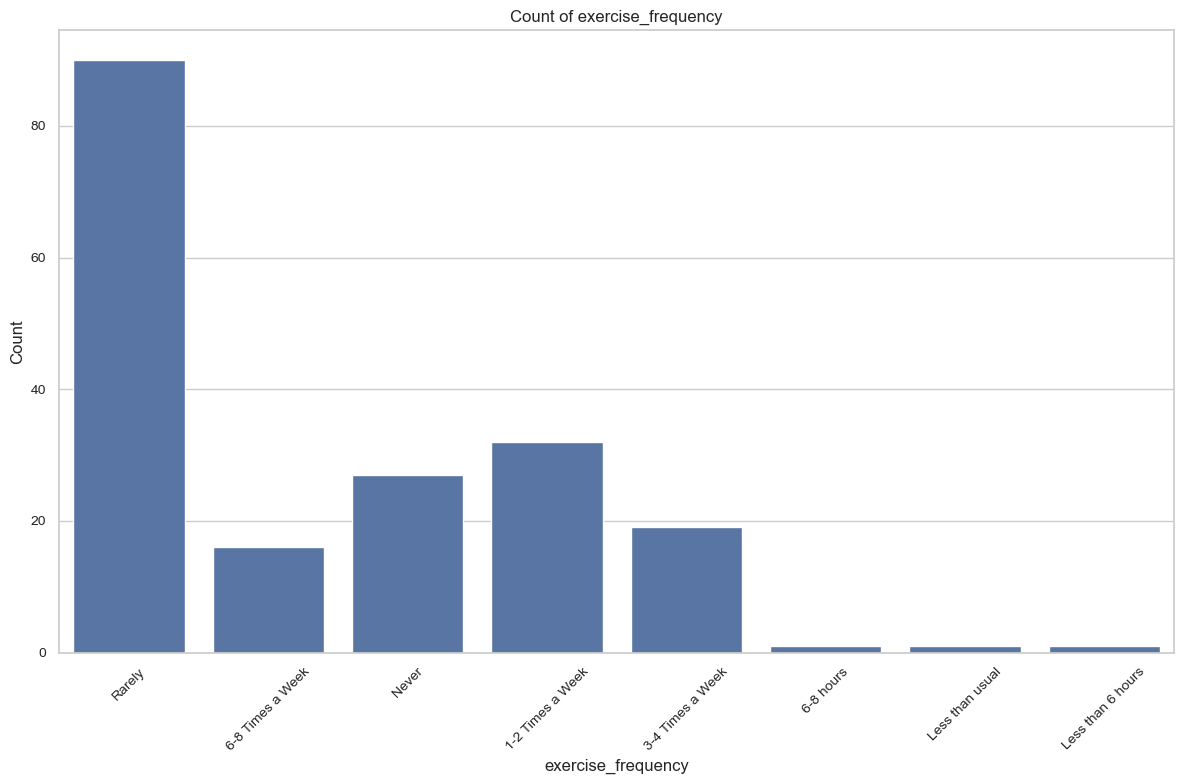

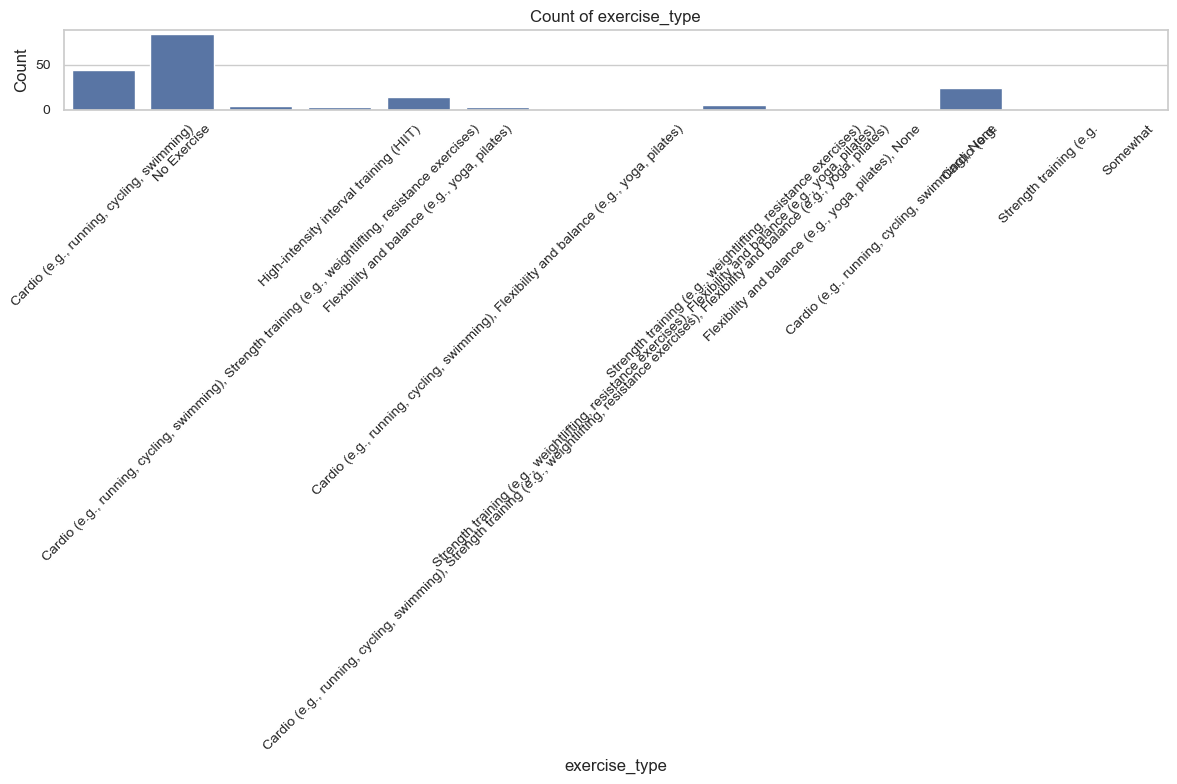

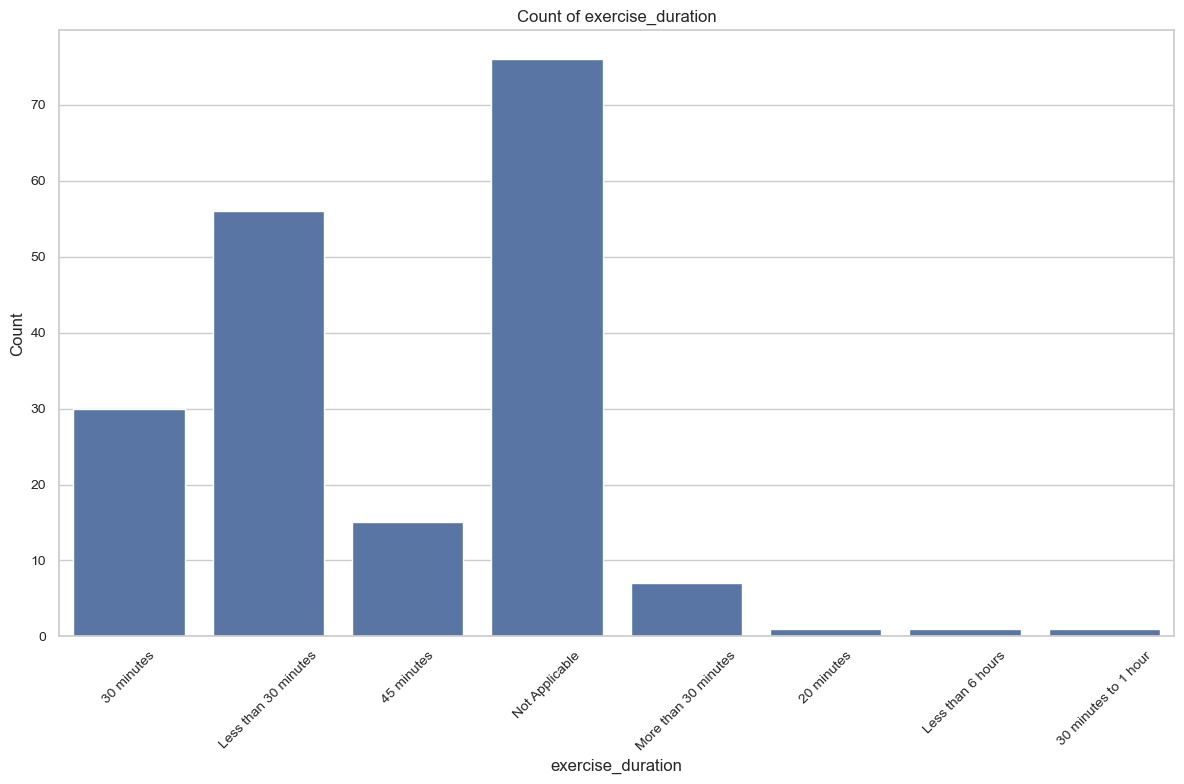

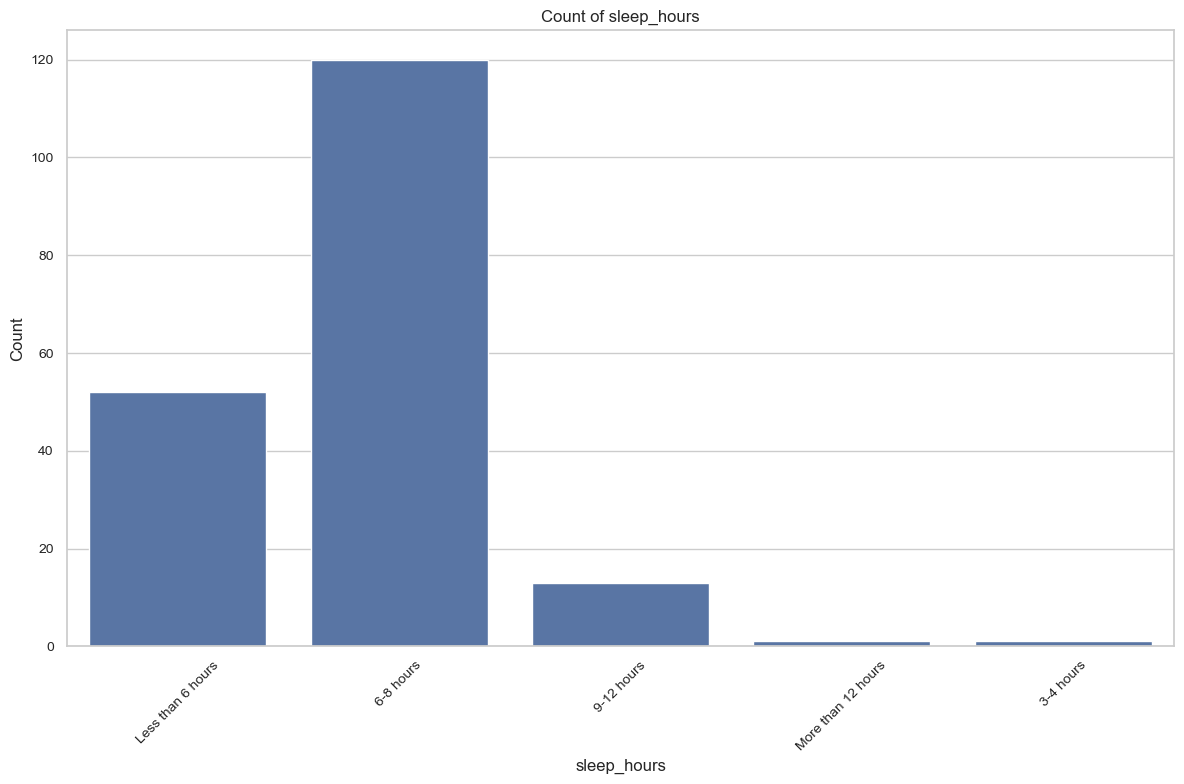

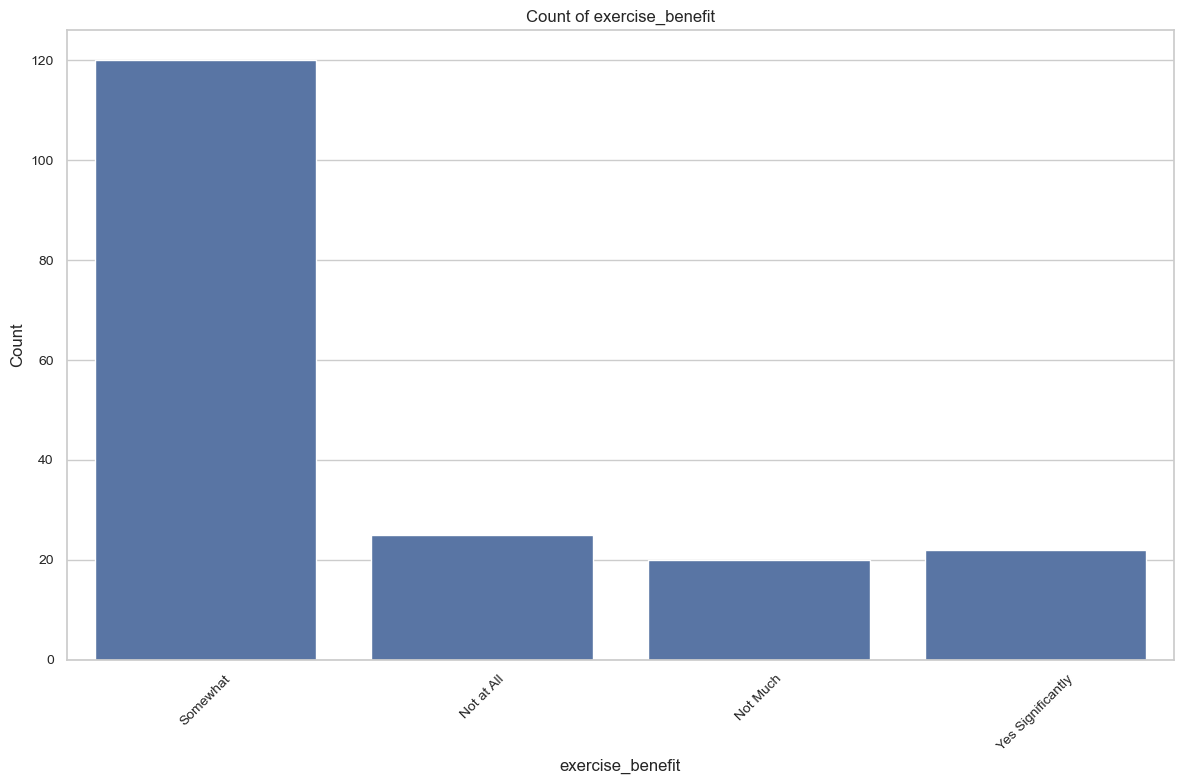

In [67]:
# function to plot graphs for categorical data:
for column in categorical_disc_columns:
    plt.figure(figsize=(12, 8))  
    sns.countplot(x=column, data=data)  
    plt.title(f'Count of {column}')  
    plt.xlabel(column, fontsize=12) 
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, fontsize=10) 
    plt.yticks(fontsize=10)  
    plt.subplots_adjust(bottom=0.15)  
    plt.tight_layout() 
    plt.show()

According to the generated plots, the dataset primarily consists of individuals aged 20–25 years (approximately 110 people), followed by those aged 15–20 years (around 40 people) and under 15 years old (about 18 people), and so on. The least represented age group includes individuals over 35 years old.
The majority of individuals in the dataset experience hormonal imbalance (hormonal_imbalance), with approximately 110 cases compared to around 85 individuals without this condition. Most individuals do not have a diagnosis of hyperandrogenism (hyperandrogenism), with around 30 cases compared to approximately 155 without the diagnosis. Additionally, about 50 individuals are diagnosed with hirsutism (hirsutism), while around 130 do not have this condition.
A vast majority of individuals in the dataset (approximately 175 compared to only 10) do not experience conception difficulties (conception_difficulty). Most individuals do not have insulin resistance (insulin_resistance), with about 160 cases without the condition versus 20 cases with it.
Regarding physical activity, the most common exercise frequency is infrequent workouts (approximately 90 individuals), followed by 1–2 times per week (around 35), never exercising (about 30), 3–4 times per week (around 19), and 6–8 times per week (around 17), with smaller numbers in other categories. The majority of individuals in the dataset either do not engage in physical exercise at all or primarily participate in cardio and stretching activities.
Most individuals who exercise do so for less than 30 minutes (approximately 55 people), followed by 30 minutes (around 30), 45 minutes (about 15), and so on.
Regarding sleep duration, most individuals in the dataset sleep 6–8 hours (approximately 120 people), followed by fewer than 6 hours (around 50) and 9–12 hours (about 17).
Finally, most individuals in the dataset rate the impact of their physical exercise as minimal.

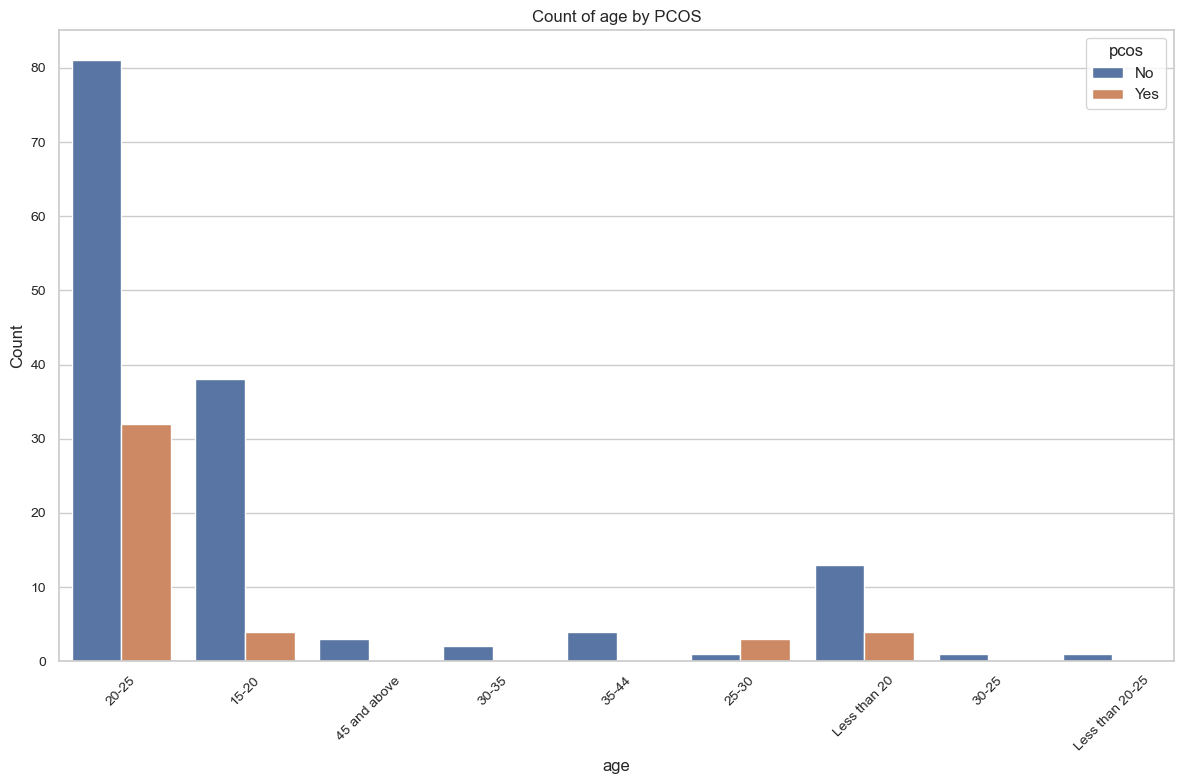

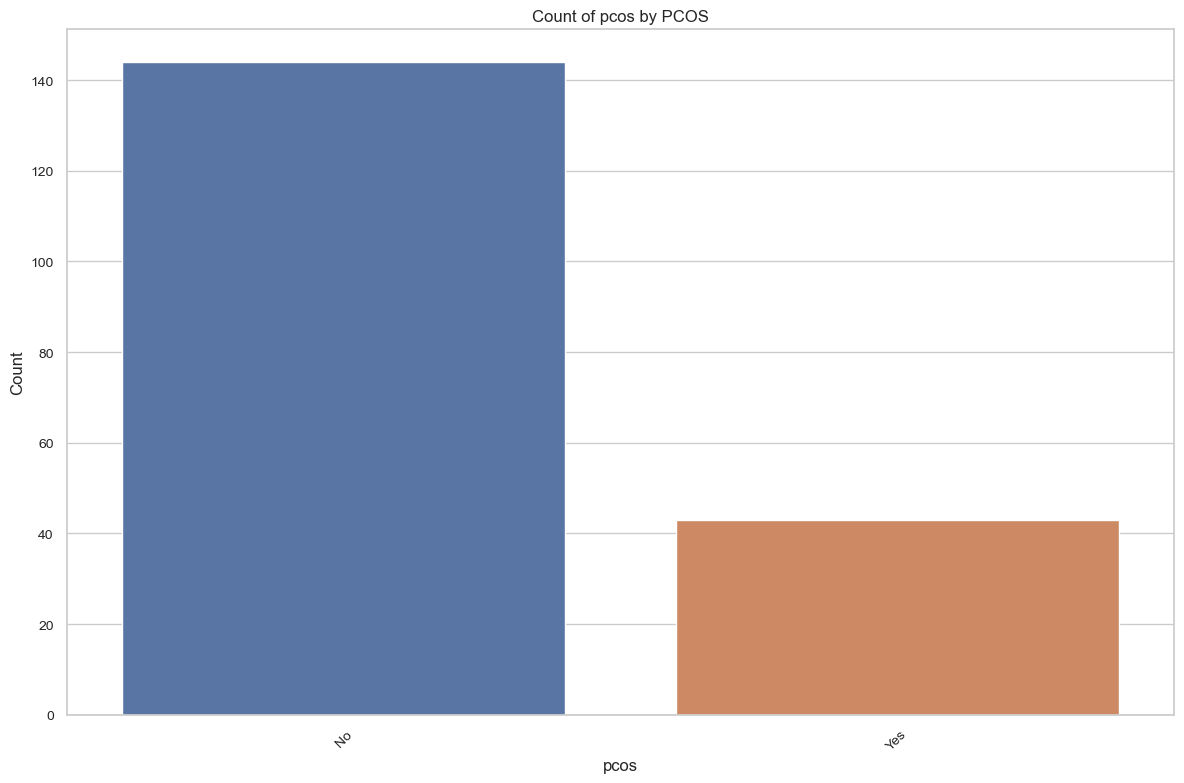

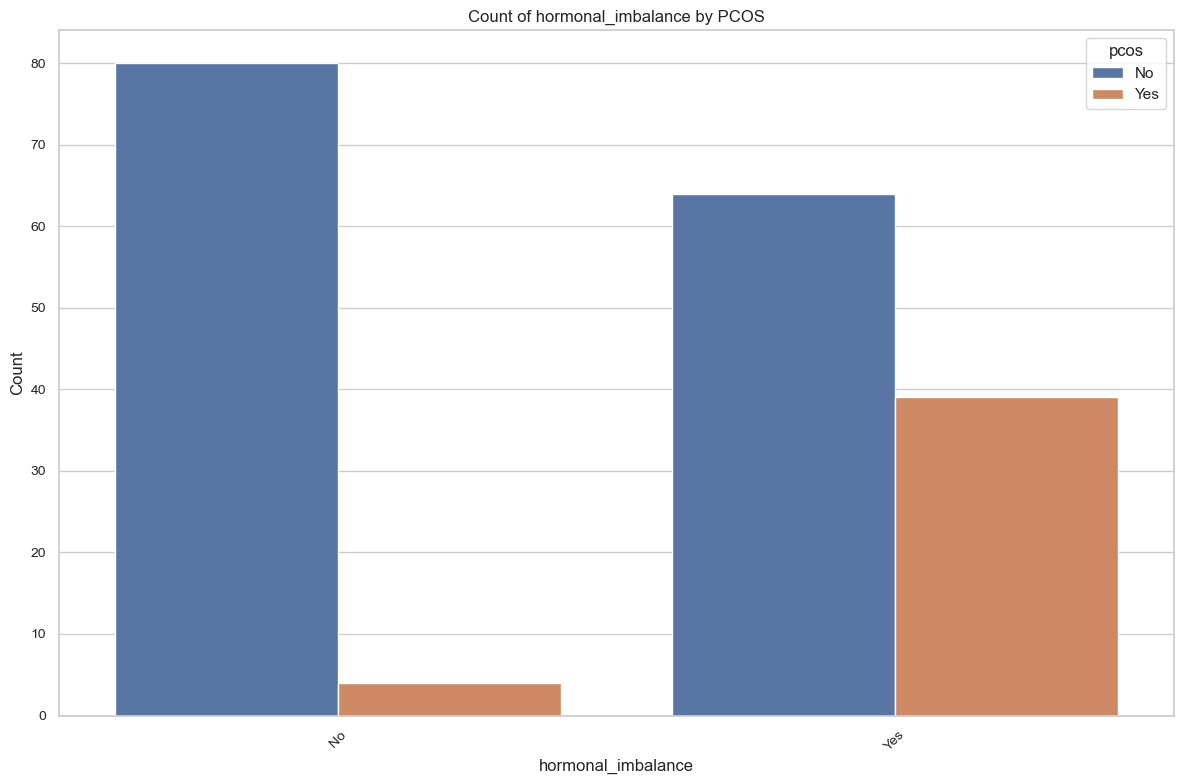

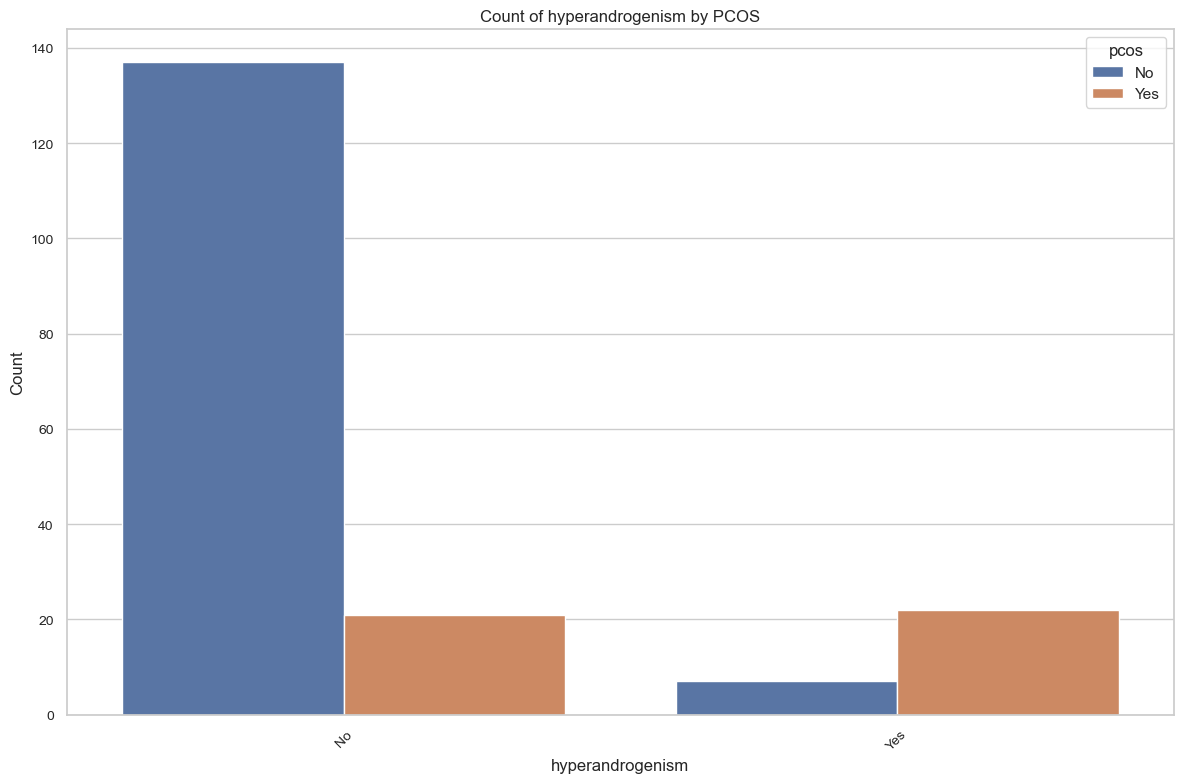

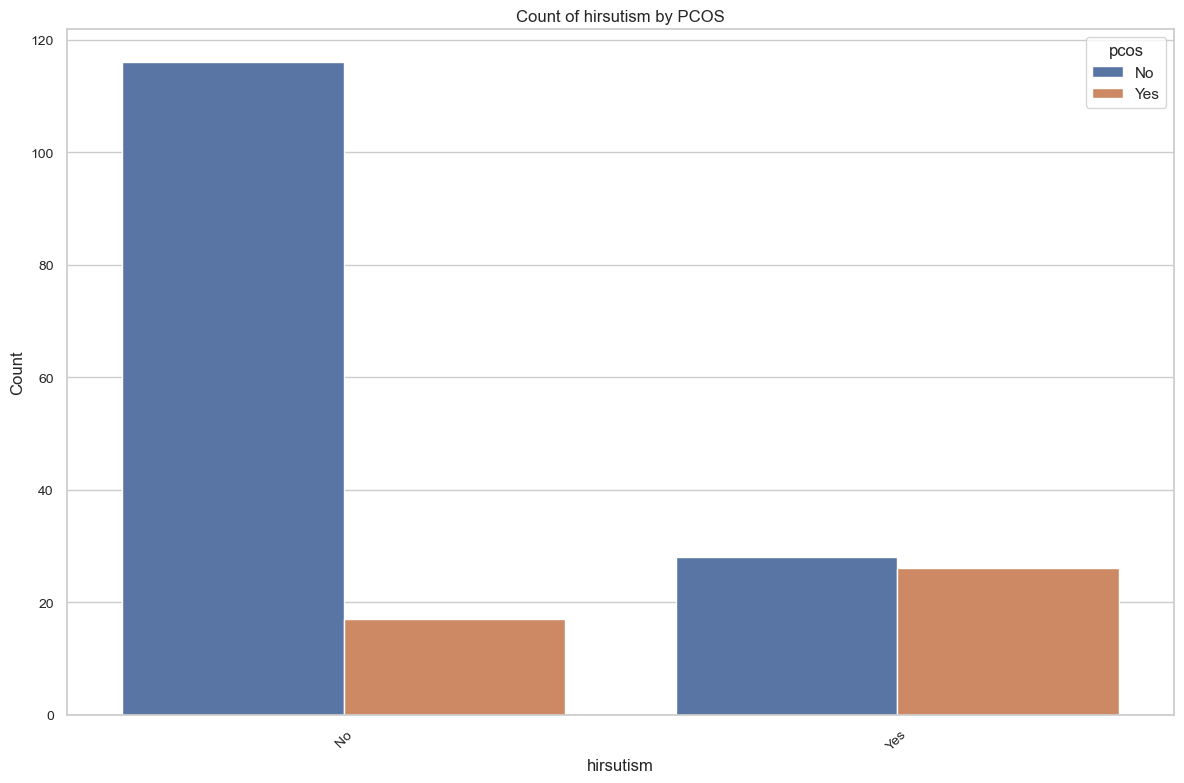

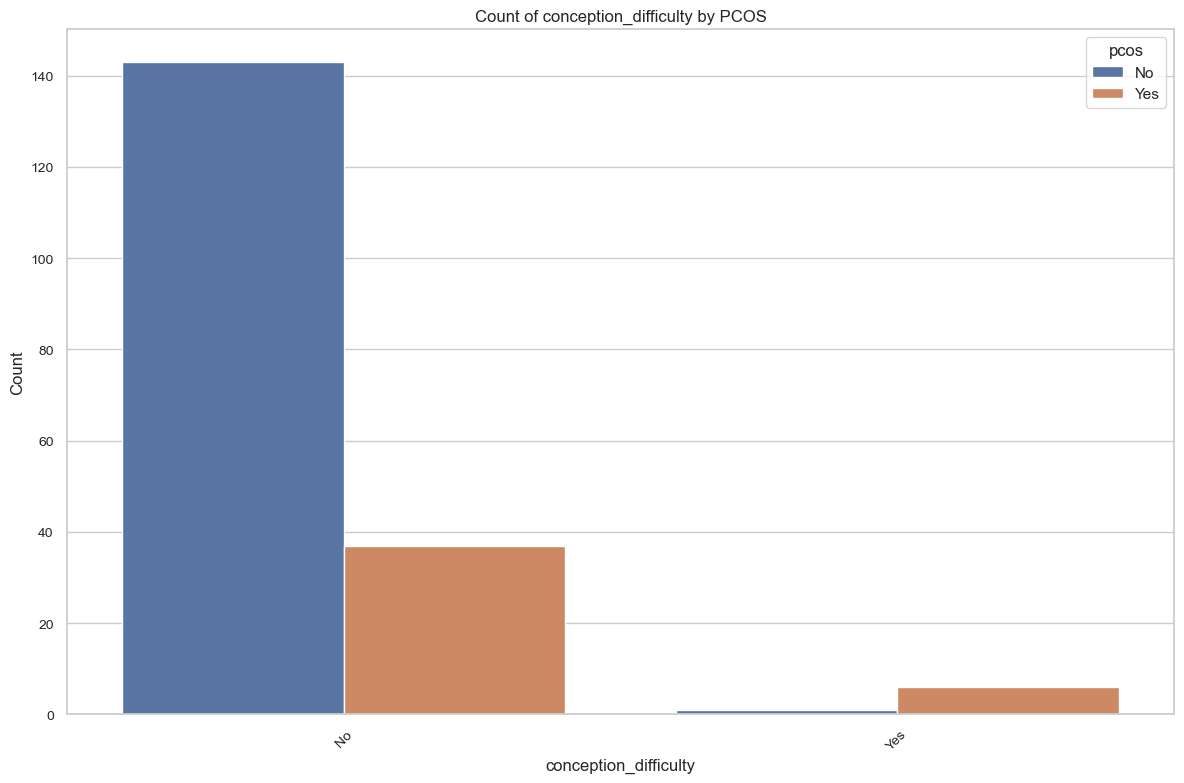

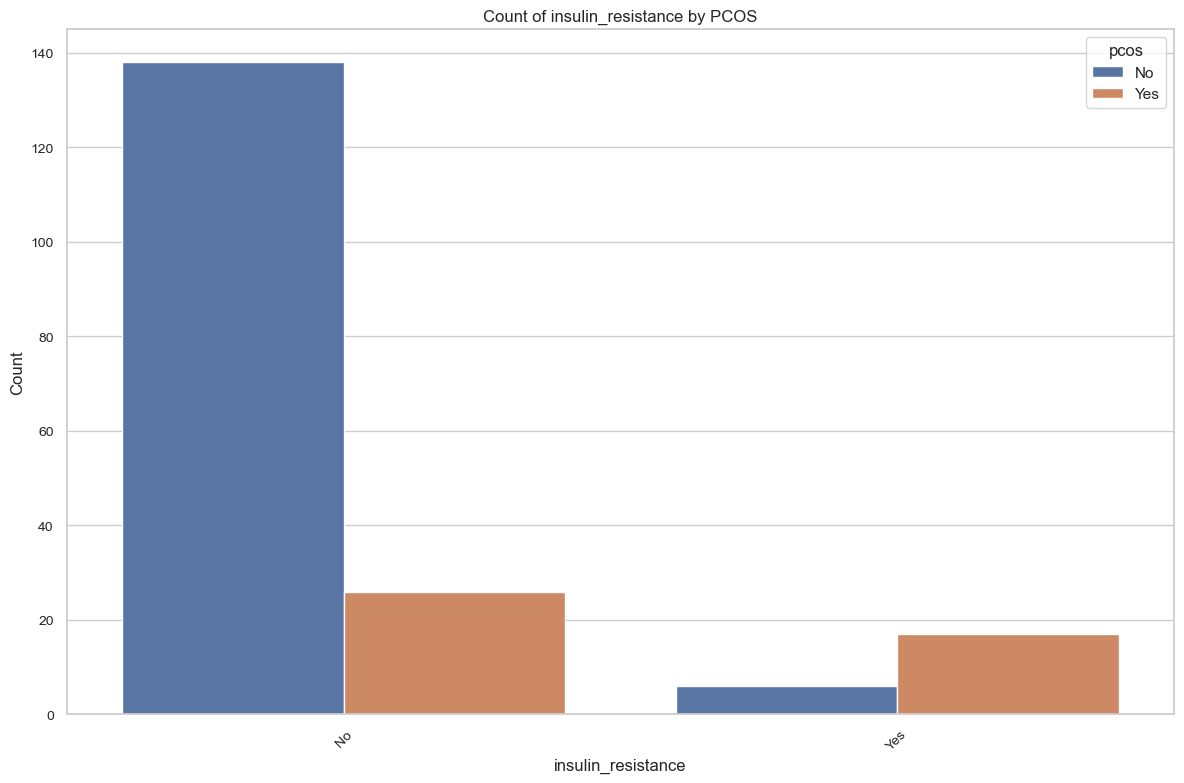

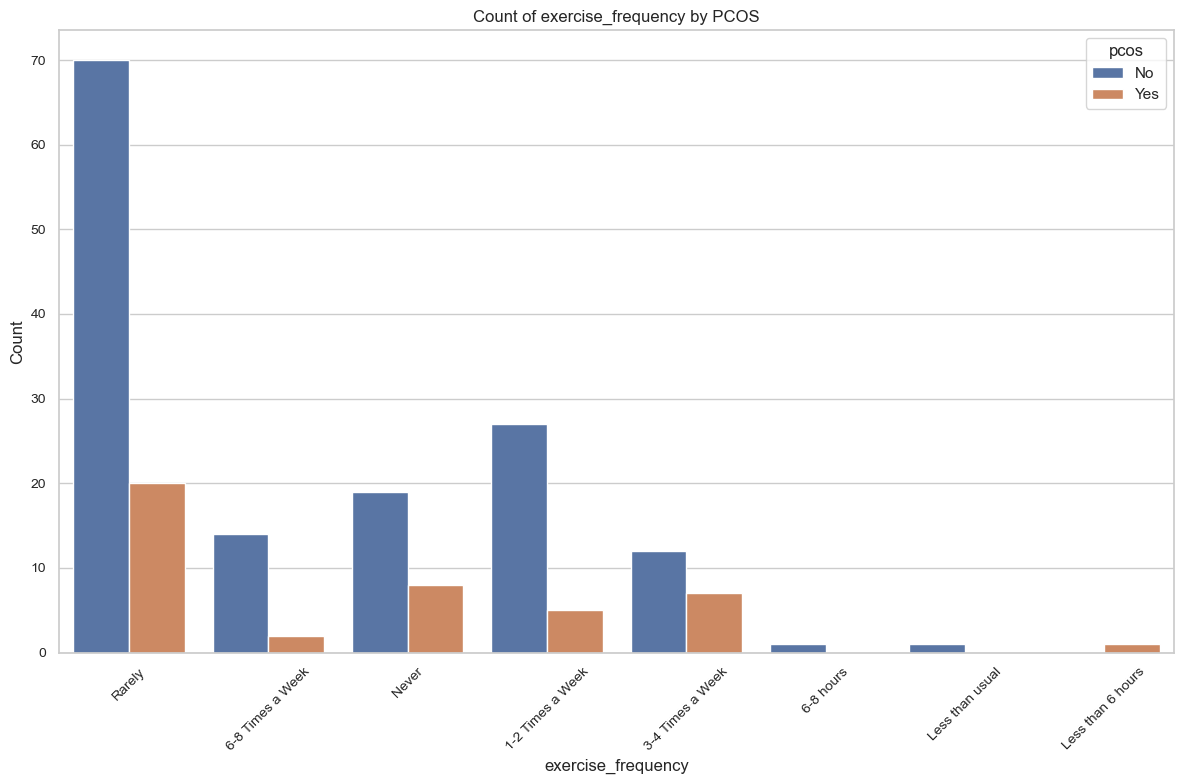

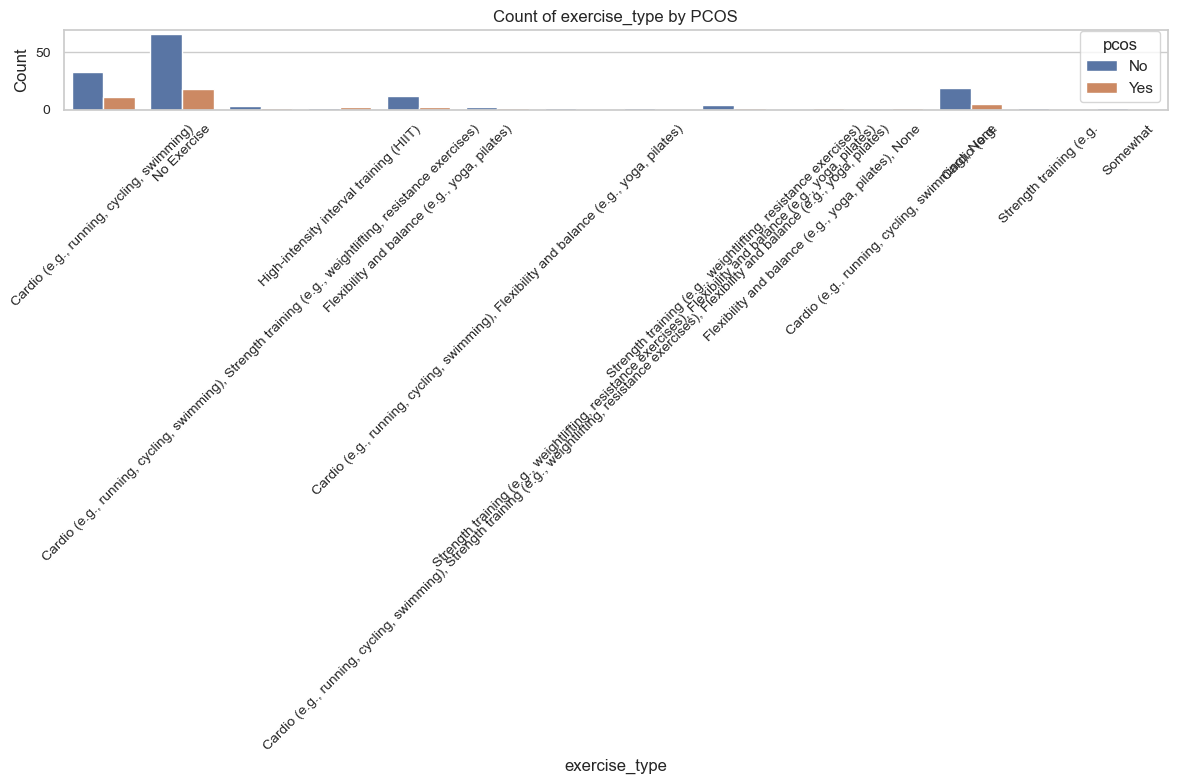

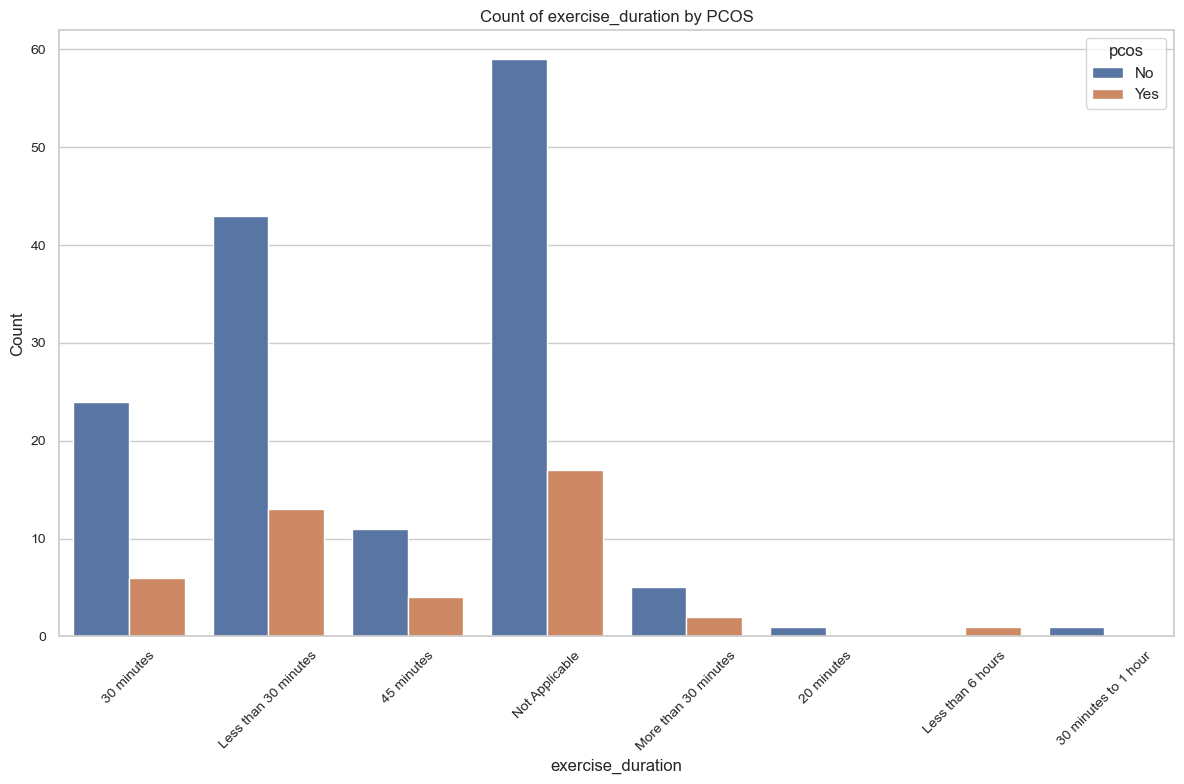

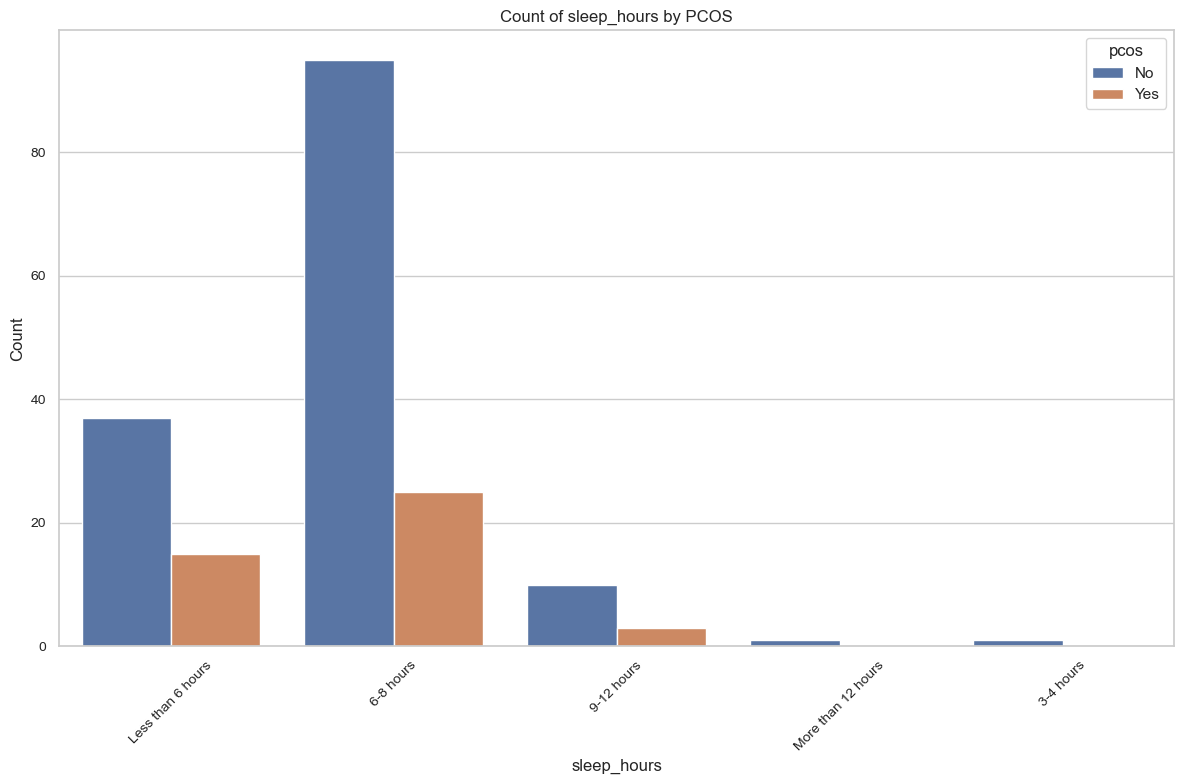

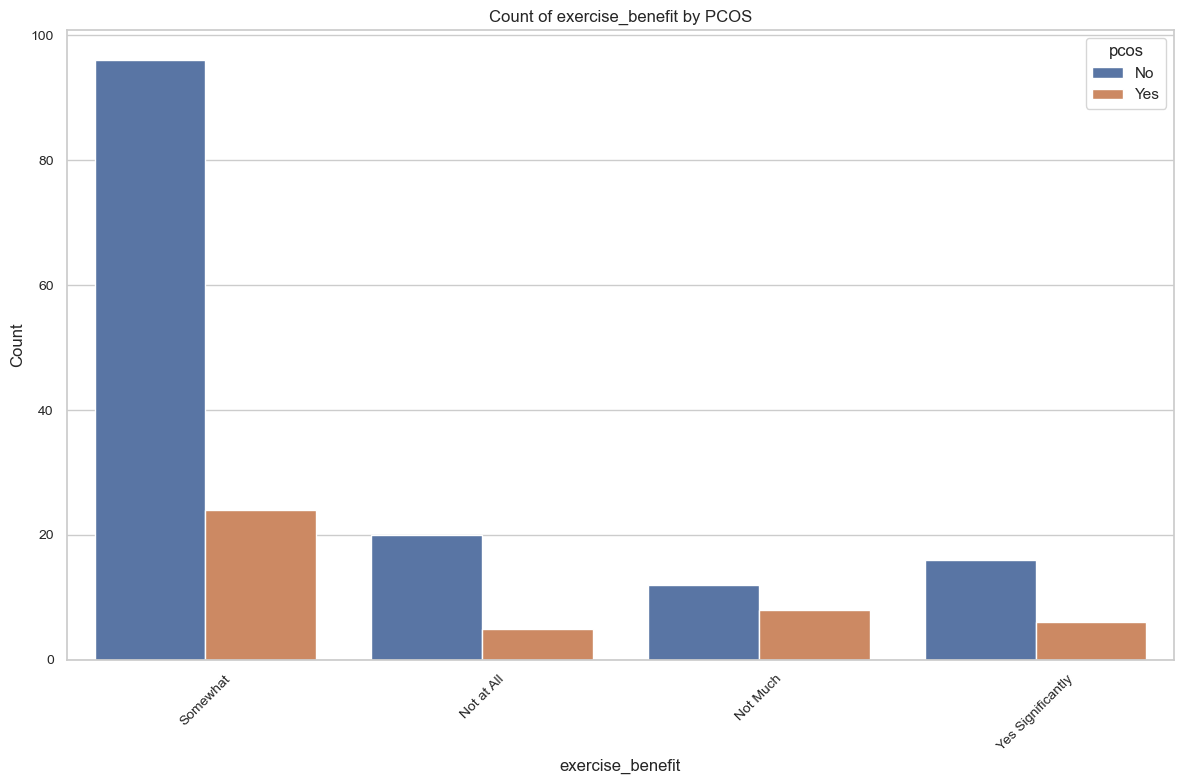

In [69]:
# Function to plot graphs for categorical data, broken down by the target 'pcos'
for column in categorical_disc_columns:
    plt.figure(figsize=(12, 8))
    sns.countplot(x=column, hue='pcos', data=data)  
    plt.title(f'Count of {column} by PCOS') 
    plt.xlabel(column, fontsize=12) 
    plt.ylabel('Count', fontsize=12) 
    plt.xticks(rotation=45, fontsize=10)  
    plt.yticks(fontsize=10)
    plt.subplots_adjust(bottom=0.15) 
    plt.tight_layout()  
    plt.show()

According to the generated plots, the dataset predominantly consists of individuals aged 15–25. Patients with PCOS are found in age groups up to 30 years, with the highest concentration in the 20–25 age group. In the 25–30 age group, the proportion of PCOS-positive patients is higher compared to healthy individuals.
The majority of individuals with PCOS experience hormonal imbalances (hormonal_imbalance). Among those with conception difficulties (conception_difficulty), most are diagnosed with PCOS. However, there are also PCOS-positive patients among those who do not have conception difficulties.
Similarly, the majority of individuals with insulin resistance (insulin_resistance) are diagnosed with PCOS. However, there are also some PCOS cases among those without insulin resistance, though significantly fewer. The same trend is observed for hyperandrogenism (hyperandrogenism), where most affected individuals have PCOS, but PCOS cases are still present, though less frequent, among those without the condition.
For hirsutism (hirsutism), the distribution is roughly 50/50 between healthy individuals and those with PCOS. The impact of exercise frequency on PCOS is difficult to determine. Most PCOS-positive patients in the dataset exercise infrequently, but infrequent exercisers also form the largest group overall.
Most PCOS-positive individuals either do not engage in any physical exercise or primarily do cardio workouts. Additionally, no clear relationship can be identified between PCOS and the duration of physical activity or sleep duration.

Now let's examine the relationships between the features in the dataset data.

In [70]:
# Specify the list of continuous features
interval_cols = ['weight_kg']

In [71]:
# Construct a correlation matrix, including categorical features, using phik_matrix()
data.phik_matrix(interval_cols=interval_cols) 

,age,weight_kg,pcos,hormonal_imbalance,hyperandrogenism,hirsutism,conception_difficulty,insulin_resistance,exercise_frequency,exercise_type,exercise_duration,sleep_hours,exercise_benefit
age,1.000000,0.445648,0.205046,0.055383,0.000000,0.047573,0.053321,0.026424,0.028910,0.360440,0.000000,0.000000,0.043208
weight_kg,0.445648,1.000000,0.221596,0.162083,0.000000,0.107361,0.141641,0.152450,0.217765,0.526234,0.258260,0.000000,0.114614
pcos,0.205046,0.221596,1.000000,0.552148,0.725650,0.536451,0.383627,0.623703,0.128797,0.000000,0.000000,0.000000,0.123315
hormonal_imbalance,0.055383,0.162083,0.552148,1.000000,0.417326,0.480237,0.090709,0.274161,0.000000,0.000000,0.103981,0.000000,0.000000
hyperandrogenism,0.000000,0.000000,0.725650,0.417326,1.000000,0.574356,0.504424,0.582911,0.155912,0.182332,0.185510,0.000000,0.159687
hirsutism,0.047573,0.107361,0.536451,0.480237,0.574356,1.000000,0.315059,0.519131,0.000000,0.000000,0.000000,0.000000,0.217825
conception_difficulty,0.053321,0.141641,0.383627,0.090709,0.504424,0.315059,1.000000,0.187998,0.000000,0.365393,0.457277,0.200579,0.000000
insulin_resistance,0.026424,0.152450,0.623703,0.274161,0.582911,0.519131,0.187998,1.000000,0.159918,0.000000,0.000000,0.000000,0.000000
exercise_frequency,0.028910,0.217765,0.128797,0.000000,0.155912,0.000000,0.000000,0.159918,1.000000,0.318997,0.820166,0.000000,0.303228
exercise_type,0.360440,0.526234,0.000000,0.000000,0.182332,0.000000,0.365393,0.000000,0.318997,1.000000,0.500681,0.732120,0.000000


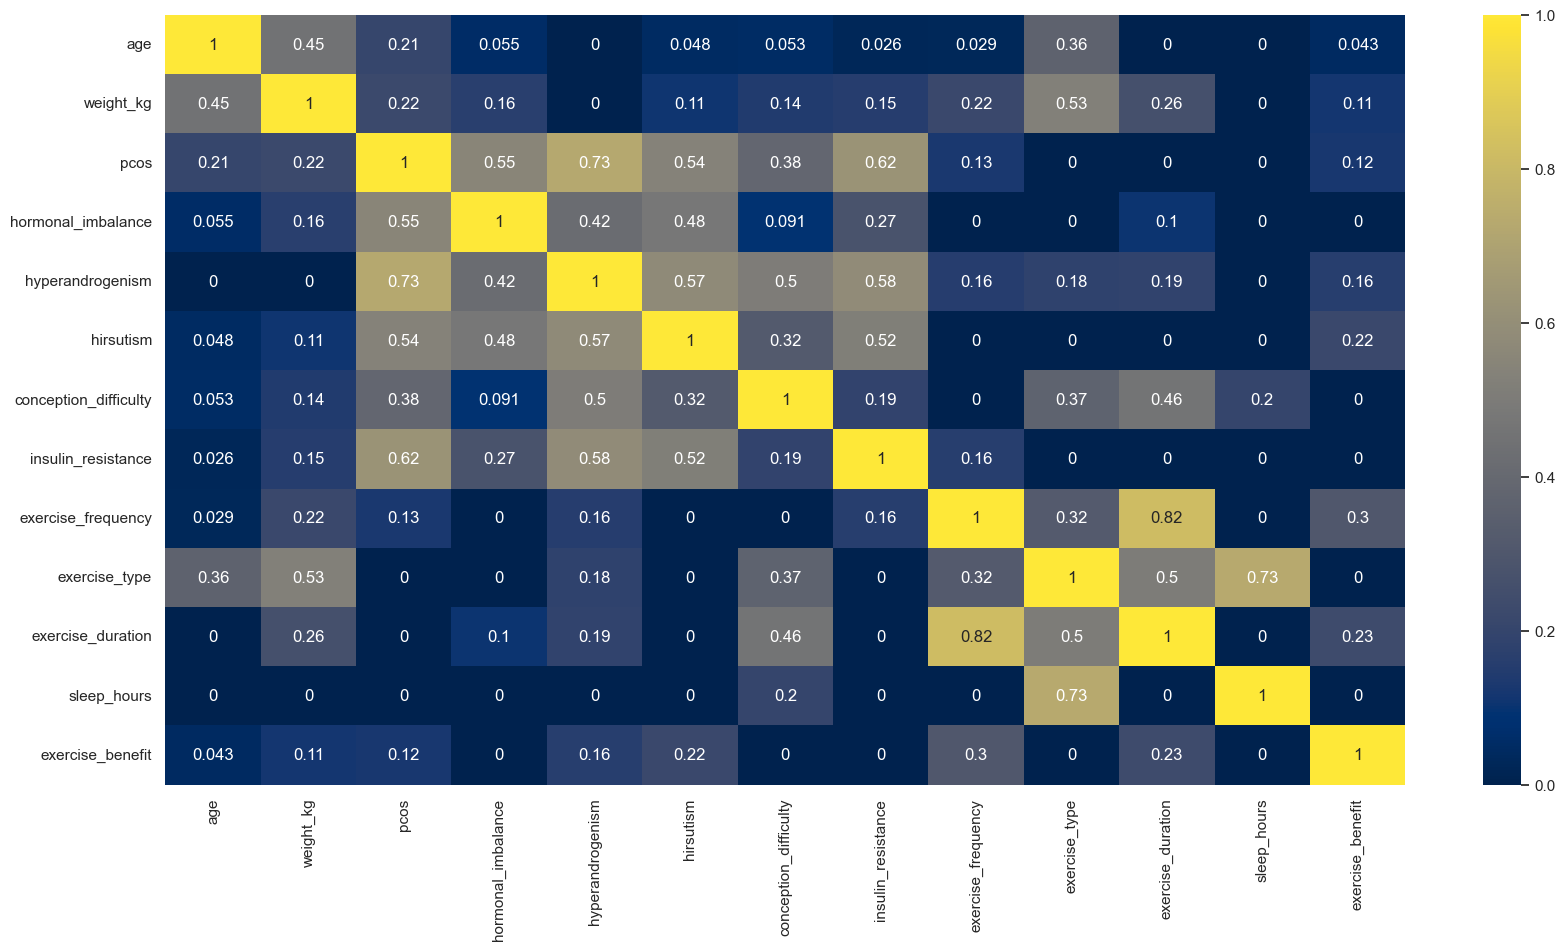

In [72]:
#Visualize the resulting correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(data.phik_matrix(interval_cols=interval_cols), annot=True, cmap='cividis');

The key observations from the correlation matrix are as follows: PCOS has a strong positive correlation with hyperandrogenism (0.73), insulin resistance (0.62), hormonal imbalance (0.55), hirsutism (0.54), and conception difficulty (0.38). There are weak or insignificant correlations with weight_kg (0.22), age (0.21), exercise frequency (0.13), and exercise benefit (0.12). There are zero correlations, possibly due to the absence of a linear relationship, with exercise type, exercise duration, and sleep hours. No multicollinearity was detected in the data.

## Predictive Modeling

In [73]:
# converting the data in the 'pcos' column: 0-No, 1-Yes
# creating a LabelEncoder object
encoder = LabelEncoder()
# creating a dictionary for mapping.
mapping = {'Yes': 1, 'No': 0}
# converting the values to numerical labels using the map function.
data['pcos'] = data['pcos'].map(mapping)

In [74]:
# сheck unique values in the 'pcos' column after conversion
data['pcos'].unique()

array([0, 1], dtype=int64)

In [75]:
# check the ratio of the 0 and 1 values in the feature
data['pcos'].value_counts()

pcos
0    144
1     43
Name: count, dtype: int64

In [76]:
# converting our object type data to category type
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype('category')

In [77]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
# split our data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    data.drop(['pcos'], axis=1),
    data['pcos'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify=data['pcos'])
X_train.shape, X_val.shape

((140, 12), (47, 12))

In [78]:
# specify the categorical features
cat_columns = ['age', 'hormonal_imbalance', 'hyperandrogenism',
       'hirsutism', 'conception_difficulty', 'insulin_resistance',
       'exercise_frequency', 'exercise_type', 'exercise_duration',
       'sleep_hours', 'exercise_benefit'] 

In [79]:
# specify the numerical features
num_columns = ['weight_kg']

In [80]:
ohe_columns = cat_columns

Next, let's build our pipeline.

In [ ]:
# transform categorical and numerical data using ColumnTransformer
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),  # Заполняем пропущенные значения медианой
             ('scaler', StandardScaler())  # Стандартизируем числовые данные
         ]), num_columns),
        
        ('cat', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполняем пропущенные значения наиболее частым значением
             ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))  # Преобразуем категориальные данные
         ]), cat_columns)
    ]) 
# creating a final pipeline with SMOTE for balancing classes
pipe_final = ImbPipeline([
    ('preprocessor', data_preprocessor),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  
    ('model', LGBMClassifier(random_state=42, class_weight='balanced'))  
])

# hyperparameter tuning
param_dis = [
    # LightGBM
    {
        'model': [LGBMClassifier(random_state=42, categorical_feature=cat_columns)],
        'model__n_estimators': [100, 200, 300], 
        'model__learning_rate': [0.01, 0.1, 0.2], 
        'model__num_leaves': [31, 63, 127], 
        'model__scale_pos_weight': [1, 3, 5, 6, 7], 
        'preprocessor': ['passthrough'],  
        'smote': ['passthrough']  
    },
   
    # XGBoost
    {
        'model': [XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='auc', enable_categorical=True)],
        'model__n_estimators': [100, 200, 300], 
        'model__learning_rate': [0.01, 0.1, 0.2], 
        'model__max_depth': [5, 7, 9],  
        'model__scale_pos_weight': [1, 3, 5, 6, 7], 
        'preprocessor': [data_preprocessor],  
        'smote': [SMOTE(sampling_strategy='auto', random_state=42)]  
    },

    # CatBoost
    {
        'model': [CatBoostClassifier(random_state=42, cat_features=cat_columns, verbose=0)],
        'model__iterations': [500, 1000, 1500], 
        'model__learning_rate': [0.01, 0.1, 0.2], 
        'model__depth': [6, 8, 10], 
        'model__scale_pos_weight': [1, 3, 5, 6, 7], 
        'preprocessor': ['passthrough'],  
        'smote': ['passthrough']  
    }
]

# hyperparameter search
random_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_dis,
    cv=10,
    n_iter=20,
    scoring='roc_auc',
    refit='roc_auc',
    n_jobs=-1,
    random_state=42
)
# model training
random_search.fit(X_train, y_train)

In [82]:
# best parameters
print(f'best parameters: {random_search.best_params_}')
# model evaluation
print(f'best ROC-AUC: {random_search.best_score_}')

best parameters: {'smote': 'passthrough', 'preprocessor': 'passthrough', 'model__scale_pos_weight': 6, 'model__num_leaves': 31, 'model__n_estimators': 300, 'model__learning_rate': 0.01, 'model': LGBMClassifier(categorical_feature=['age', 'hormonal_imbalance',
                                    'hyperandrogenism', 'hirsutism',
                                    'conception_difficulty',
                                    'insulin_resistance', 'exercise_frequency',
                                    'exercise_type', 'exercise_duration',
                                    'sleep_hours', 'exercise_benefit'],
               random_state=42)}
best ROC-AUC: 0.8559848484848483


Checking with validation set

In [90]:
# prediction the probabilities for the positive class (class 1)
y_val_pred = random_search.predict(X_val)
y_val_proba = random_search.predict_proba(X_val)[:,1]
# сalculation the ROC-AUC score using the true labels and predicted probabilities
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f'ROC-AUC: {roc_auc:.4f}')

ROC-AUC: 0.8144


The ROC AUC metric (validation set) is 0.8144. The model's performance is quite good.

Next, we compare our best model with the constant model.

In [96]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# Check the predictions of the constant model on the test data
y_dummy_pred = dummy_model.predict(X_val)
y_dummy_proba = dummy_model.predict_proba(X_val)[:, 1] 

# Evaluate the performance of the constant model
dummy_roc_auc = roc_auc_score(y_val, y_dummy_pred)
print(f'ROC-AUC metric for the constant model: {dummy_roc_auc}')

Метрика ROC-AUC для константной модели: 0.5


Our best model significantly outperforms the constant model, which confirms that all efforts in feature creation, tuning, and cross-validation are justified. It also confirms that our model makes a substantial contribution to improving prediction quality compared to the simple approach.

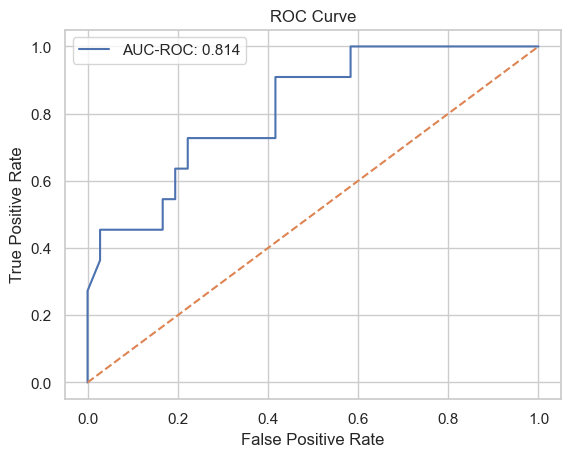

In [92]:
# plot the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

A value of 0.814 indicates good model quality. The closer the AUC (area under the curve) is to 1, the better the model distinguishes between classes. If the AUC were 0.5, it would mean random guessing (the model is useless). The curve is far from the diagonal. The blue curve shows that the model performs better than random guessing, as it is above the diagonal.

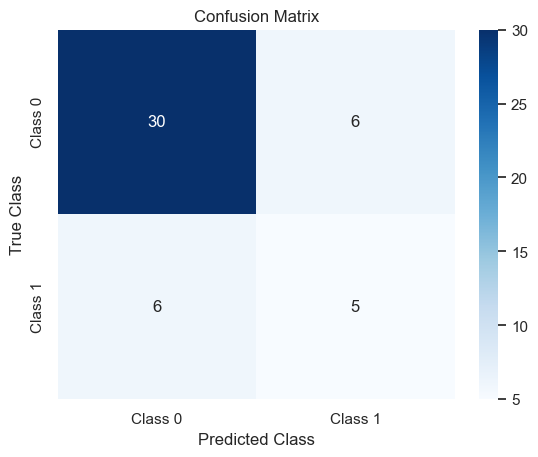

In [94]:
# confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

From the confusion matrix, the following conclusions can be made: 30 patients were predicted as PCOS negative, which means a correct prediction. 6 patients were predicted as PCOS negative, but in reality, they have the condition, indicating a model error. 6 patients were incorrectly predicted as PCOS positive, although they do not have the condition. 5 patients were correctly predicted as PCOS positive (true positives). The model demonstrates high accuracy in predictions for both categories, with a small number of false positives. However, there are type II errors (false negatives), where patients with the condition were incorrectly predicted as healthy. These errors can be critical if it is necessary to prevent the disease from progressing in patients who would not receive treatment without the correct diagnosis.

Based on the requirements, we should focus on the ROC AUC metric. However, if the situation involves a scenario where missing true positive results can have serious consequences, we might consider using a metric like recall. In this case, we could try to minimize the critical error to zero by adjusting the classification threshold.

### Feature Importance Analysis

In [107]:
# Extract the model from the pipeline
best_model = random_search.best_estimator_
model = best_model.named_steps['model']

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
importance_data = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by importance
importance_data = importance_data.sort_values(by='Importance', ascending=False)

# Display the result
print(importance_data)

                  Feature  Importance
1               weight_kg         797
3        hyperandrogenism         227
2      hormonal_imbalance         185
10            sleep_hours         174
4               hirsutism         136
6      insulin_resistance          51
0                     age           0
5   conception_difficulty           0
7      exercise_frequency           0
8           exercise_type           0
9       exercise_duration           0
11       exercise_benefit           0


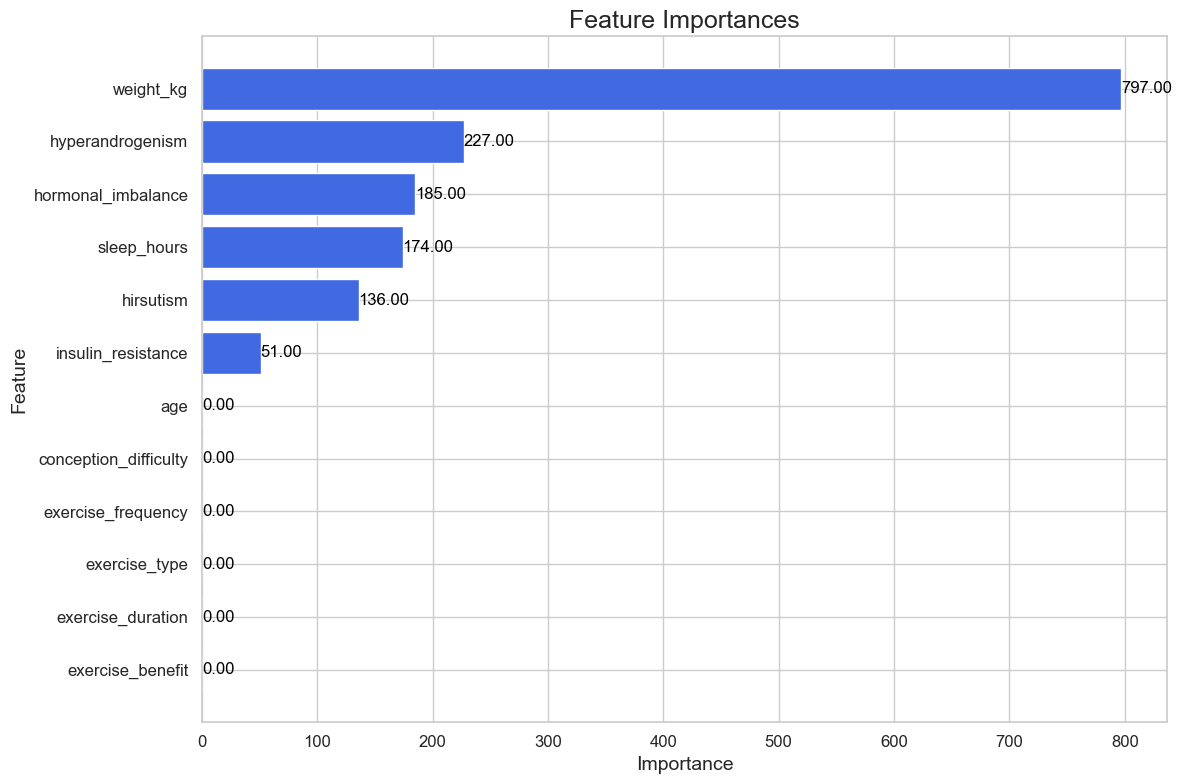

In [108]:
# Feature Importance Visualization
# Style the plots using seaborn
sns.set(style="whitegrid")

# Set figure size
plt.figure(figsize=(12, 8))

# Create a horizontal bar chart
bars = plt.barh(importance_data['Feature'], importance_data['Importance'], color='royalblue')
plt.title('Feature Importances', fontsize=18)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Add values to the bars for better readability
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}', va='center', ha='left', fontsize=12, color='black')

# Invert the y-axis so that the most important feature is on top
plt.gca().invert_yaxis()

# Set font size for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

The analysis revealed that the most important features influencing the model’s predictions are weight, hyperandrogenism, and hormonal imbalance, with these factors playing a significant role in predicting the likelihood of polycystic ovary syndrome (PCOS). Weight (weight_kg) emerged as the most important factor, followed by hyperandrogenism and hormonal imbalance, both of which are strongly associated with the condition. Other notable features include sleep hours and hirsutism, although their impact is less pronounced. Insulin resistance also has some relevance, but it is of lower importance compared to the other factors mentioned. On the other hand, features related to age, conception difficulty, exercise frequency, exercise type, exercise duration, and exercise benefit were found to have little to no impact on the model’s predictions, as they received a feature importance score of zero. These findings suggest that factors related to hormonal imbalances and weight are more critical in determining the likelihood of PCOS, while physical activity and exercise-related variables do not appear to significantly influence the outcome in this model.

### Prediction on Test Data

In [109]:
test.head()

,age,weight_kg,hormonal_imbalance,hyperandrogenism,hirsutism,conception_difficulty,insulin_resistance,exercise_frequency,exercise_type,exercise_duration,sleep_hours,exercise_benefit
ID,,,,,,,,,,,,
0,20-25,54.0,No,No,No,No,No,Rarely,No Exercise,Less than 30 minutes,6-8 hours,Somewhat
1,20-25,65.0,Yes,No,No,No,No,3-4 Times a Week,No Exercise,Not Applicable,6-8 hours,Somewhat
2,20-25,64.0,Yes,No,No,No,No,6-8 Times a Week,Cardio (e.g.,Not Applicable,6-8 hours,Somewhat
3,Less than 20,57.0,Yes,No,Yes,No,Yes,Rarely,No Exercise,6-8 hours,6-8 hours,Somewhat
4,Less than 20,6.0,Yes,No,Yes,No,No,Rarely,Cardio (e.g.,30 minutes,6-8 hours,Somewhat


In [110]:
test = test.reset_index()

In [111]:
test.head(1)

,ID,age,weight_kg,hormonal_imbalance,hyperandrogenism,hirsutism,conception_difficulty,insulin_resistance,exercise_frequency,exercise_type,exercise_duration,sleep_hours,exercise_benefit
0,0,20-25,54.0,No,No,No,No,No,Rarely,No Exercise,Less than 30 minutes,6-8 hours,Somewhat


In [112]:
test_id = test['ID']

In [113]:
test = test.drop(['ID'], axis =1)

In [114]:
# converting our object type data to category type
for col in test.select_dtypes(include=['object']).columns:
    test[col] = test[col].astype('category')

In [115]:
best_model = random_search.best_estimator_

In [116]:
# applying transformations
y_test_proba = best_model.predict_proba(test)[:, 1]
y_test_pred = best_model.predict(test)

In [117]:
# creating the submission file
submission = pd.DataFrame({
    'ID': test_id,
    'PCOS': y_test_proba
})

# saving the submission file
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.


# Сonclusion

As part of this project, the goal was to analyze the impact of lifestyle factors on polycystic ovary syndrome (PCOS) using data analysis methods. A preliminary analysis and data preprocessing were conducted, including the transformation of categorical and numerical variables, handling of missing values, and addressing class imbalance using the SMOTE technique.
The analysis revealed significant correlations between PCOS and factors such as hyperandrogenism, insulin resistance, hormonal imbalance, hirsutism, and difficulties with conception. Gradient boosting algorithms (LGBM, XGBoost, CatBoost) were used for model development, with hyperparameter tuning. Additionally, feature selection techniques based on feature importance and SHAP analysis were applied to enhance interpretability.
The best-performing model was LGBMClassifier with the parameters scale_pos_weight=6, num_leaves=31, n_estimators=300, and learning_rate=0.01. It achieved the highest ROC-AUC score (0.8559 on the training set and 0.8144 on validation), demonstrating a strong ability to distinguish PCOS patients from healthy individuals.
The results confirm that lifestyle factors play a significant role in the development of PCOS. However, the impact of specific parameters, such as the frequency of physical activity or sleep duration, requires further investigation. The developed approach, incorporating data balancing, model interpretability, and feature selection, can be used to identify high-risk groups and personalize recommendations for patient management. On the Kaggle platform, the results on the test data showed a Private Score of -0.836 and a Public Score of 0.935, further confirming the effectiveness of the model.